# 0.0 IMPORTS

In [2]:
import io
import requests
import math
import random
import pickle
import warnings
import inflection

import pandas              as pd
import numpy               as np
import seaborn             as sns

from scipy                 import stats  as ss
from matplotlib            import pyplot as plt
from IPython.display       import Image
from IPython.core.display  import HTML
from datetime              import date

## 0.1. Helper Functions

In [3]:
warnings.filterwarnings("ignore") 

# improving dataset visualization
pd.set_option('display.max_columns',500)
pd.set_option('display.max_rows',150)
pd.set_option('display.max_colwidth',150)

# tirando a notação ciêntifica dos números
pd.set_option('float_format', '{:.2f}'.format)

#Function to plot categorical data absolute and percentage values
def df_cat(col):
    a = cat_attributes_2[col].value_counts().to_frame()
    b = (cat_attributes_2[col].value_counts(normalize=True)*100).to_frame()
    df = a.merge(b, left_on=a.index, right_on=b.index)
    df.columns = [col,'absolute', 'percentage']
    df.set_index(col, inplace=True)
    return df


def jupyter_settings():
    %matplotlib inline
    %pylab inline
    
    plt.style.use( 'bmh' )
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    display( HTML( '<style>.container { width:100% !important; }</style>') )
    pd.options.display.max_columns = None
    pd.options.display.max_rows = None
    pd.set_option( 'display.expand_frame_repr', False )
    
    sns.set()
    
    
def cramer_v( x, y ):
    cm = pd.crosstab( x, y ).to_numpy()
    n = cm.sum()
    r, k = cm.shape
    
    chi2 = ss.chi2_contingency( cm )[0]
    chi2corr = max( 0, chi2 - (k-1)*(r-1)/(n-1) )
    
    kcorr = k - (k-1)**2/(n-1)
    rcorr = r - (r-1)**2/(n-1)
    
    return np.sqrt( (chi2corr/n) / ( min( kcorr-1, rcorr-1 ) ) )

## 0.2. Loading data

In [4]:
df_kc_data_raw = pd.read_csv( 'kc_house_data.csv', low_memory=False )

# 1.0 - Data Description

In [5]:
df1 = df_kc_data_raw.copy()

In [6]:
df1.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,20141013T000000,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,20141209T000000,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,20150225T000000,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,20141209T000000,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,20150218T000000,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


## 1.1. Rename Columns

In [7]:
df1.columns

Index(['id', 'date', 'price', 'bedrooms', 'bathrooms', 'sqft_living',
       'sqft_lot', 'floors', 'waterfront', 'view', 'condition', 'grade',
       'sqft_above', 'sqft_basement', 'yr_built', 'yr_renovated', 'zipcode',
       'lat', 'long', 'sqft_living15', 'sqft_lot15'],
      dtype='object')

The name of the columns is already demarcated in the snake case style, which I prefer to work on.

## 1.2. Data Dimensions

In [8]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 21613
Number of Cols: 21


In [9]:
# Deletando os ID's repetidos, deixando o último cadastrado

df1 = df1.drop_duplicates(subset = ['id'], keep = 'last')


In [10]:
print(f'Number of Rows: {df1.shape[0]}')
print(f'Number of Cols: {df1.shape[1]}')

Number of Rows: 21436
Number of Cols: 21


## 1.3. Data Types

In [11]:
df1.dtypes

id                 int64
date              object
price            float64
bedrooms           int64
bathrooms        float64
sqft_living        int64
sqft_lot           int64
floors           float64
waterfront         int64
view               int64
condition          int64
grade              int64
sqft_above         int64
sqft_basement      int64
yr_built           int64
yr_renovated       int64
zipcode            int64
lat              float64
long             float64
sqft_living15      int64
sqft_lot15         int64
dtype: object

In [12]:
df1['date'] = pd.to_datetime( df1['date'] )
df1.dtypes

id                        int64
date             datetime64[ns]
price                   float64
bedrooms                  int64
bathrooms               float64
sqft_living               int64
sqft_lot                  int64
floors                  float64
waterfront                int64
view                      int64
condition                 int64
grade                     int64
sqft_above                int64
sqft_basement             int64
yr_built                  int64
yr_renovated              int64
zipcode                   int64
lat                     float64
long                    float64
sqft_living15             int64
sqft_lot15                int64
dtype: object

## 1.4. Check NA


In [13]:
df1.isna().sum()

id               0
date             0
price            0
bedrooms         0
bathrooms        0
sqft_living      0
sqft_lot         0
floors           0
waterfront       0
view             0
condition        0
grade            0
sqft_above       0
sqft_basement    0
yr_built         0
yr_renovated     0
zipcode          0
lat              0
long             0
sqft_living15    0
sqft_lot15       0
dtype: int64

## 1.7. Descriptive Statistics

In [14]:
num_attributes = df1.select_dtypes( include=['int64', 'float64'] )

### 1.7.1. Numerical Atributes

In [15]:
# Central Tendency - mean, meadina 
ct1 = pd.DataFrame( num_attributes.apply( np.mean ) ).T
ct2 = pd.DataFrame( num_attributes.apply( np.median ) ).T

# dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame( num_attributes.apply( np.std ) ).T 
d2 = pd.DataFrame( num_attributes.apply( min ) ).T 
d3 = pd.DataFrame( num_attributes.apply( max ) ).T 
d4 = pd.DataFrame( num_attributes.apply( lambda x: x.max() - x.min() ) ).T 
d5 = pd.DataFrame( num_attributes.apply( lambda x: x.skew() ) ).T 
d6 = pd.DataFrame( num_attributes.apply( lambda x: x.kurtosis() ) ).T 

# concatenar
m = pd.concat( [d2, d3, d4, ct1, ct2, d1, d5, d6] ).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

,attributes,min,max,range,mean,median,std,skew,kurtosis
0,id,1000102.00,9900000190.00,9899000088.00,4580765328.18,3904921185.00,2876522535.73,0.24,-1.26
1,price,75000.00,7700000.00,7625000.00,541649.96,450000.00,367306.36,4.04,34.73
2,bedrooms,0.00,33.00,33.00,3.37,3.00,0.93,1.99,49.64
3,bathrooms,0.00,8.00,8.00,2.12,2.25,0.77,0.51,1.29
4,sqft_living,290.00,13540.00,13250.00,2082.70,1920.00,919.13,1.47,5.25
5,sqft_lot,520.00,1651359.00,1650839.00,15135.64,7614.00,41537.65,13.04,284.08
6,floors,1.00,3.50,2.50,1.50,1.50,0.54,0.61,-0.49
7,waterfront,0.00,1.00,1.00,0.01,0.00,0.09,11.34,126.55
8,view,0.00,4.00,4.00,0.24,0.00,0.77,3.39,10.83
9,condition,1.00,5.00,4.00,3.41,3.00,0.65,1.04,0.52


Verificando as primeiras estatísticas descritivas, vamos um range de 33 no número de quartos, vamos investigar mais a fundo essa variável, para identificar um possível outlier

<AxesSubplot:xlabel='bedrooms'>

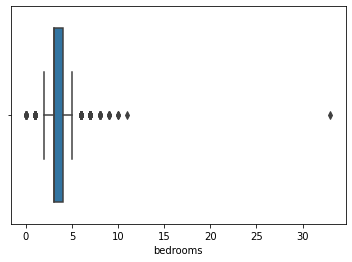

In [16]:
sns.boxplot(x=df1['bedrooms'])

analisando o gráfico, conseguimos identificar o imóvel preenchido com 33 quartos como um grande outlier, mas ainda não podemos validar se realmente o imóvel está acima dos padrões de contrução, ou se erro foi um possível erro de preenchimento

In [17]:
df1.loc[df1['bedrooms'] == 33]


,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
15870,2402100895,2014-06-25,640000.00,33,1.75,1620,6000,1.00,0,0,5,7,1040,580,1947,0,98103,47.69,-122.33,1330,4700


Análisando as demais condições do imóvel com 33 quartos, conseguimos verificar que as dmais informações não condizem para 33 quartos, como número de banheiros e a medida do lote, não condiz para 33 quartos, entao vamos assumir a premissa de um erro de prenchimento no imóvel, portando vamos retira-lo do dataset.

In [18]:
#Removendo o imóvel com 33 quartos.
df1.drop(df1.loc[df1['bedrooms'] == 33].index, inplace=True)


<AxesSubplot:xlabel='bedrooms'>

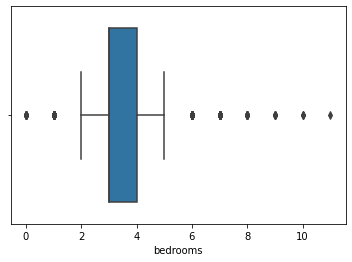

In [19]:
sns.boxplot(x=df1['bedrooms'])

# 2.0 - FEATURE ENGINEERING

In [20]:
df2 = df1.copy()

In [21]:
df2.head()

,id,date,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15
0,7129300520,2014-10-13,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650
1,6414100192,2014-12-09,538000.00,3,2.25,2570,7242,2.00,0,0,3,7,2170,400,1951,1991,98125,47.72,-122.32,1690,7639
2,5631500400,2015-02-25,180000.00,2,1.00,770,10000,1.00,0,0,3,6,770,0,1933,0,98028,47.74,-122.23,2720,8062
3,2487200875,2014-12-09,604000.00,4,3.00,1960,5000,1.00,0,0,5,7,1050,910,1965,0,98136,47.52,-122.39,1360,5000
4,1954400510,2015-02-18,510000.00,3,2.00,1680,8080,1.00,0,0,3,8,1680,0,1987,0,98074,47.62,-122.05,1800,7503


## 2.1 - Hypothesis Mind Map

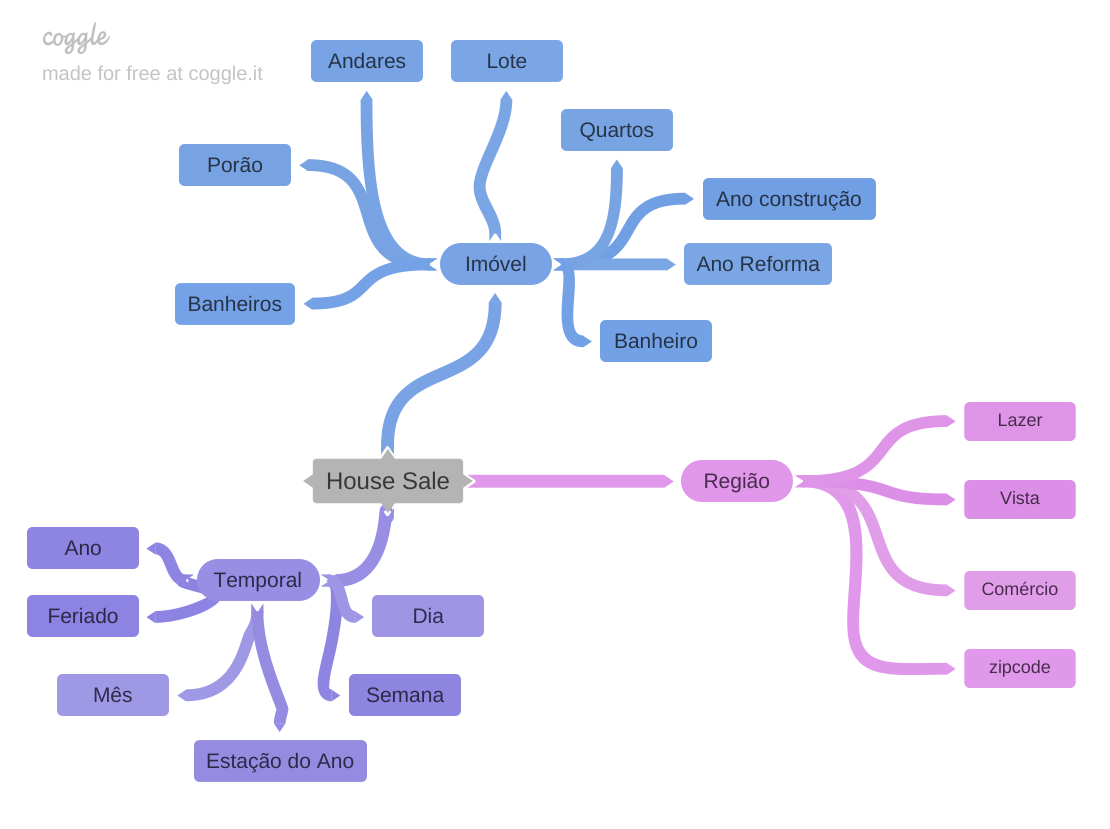

In [22]:
Image( 'IMG/House_Sale.png' )

## 2.2. Creation of Hypotheses

### 2.2.1. Region Hypothesis

- **1.** O ZipCode pode influenciar no valor do imóvel ?
- **2.** Zipcodes com mais opções de casas a venda tendem a ser mais baratos ?
- **3.** Casas em regiões com maior variedade de Comércio são 50% mais caros na média ?
- **4.** Casas com vista privilegiada são 40% mais caras que na média ?
- **5.** Casas com vista para a água são 50% mais caras que na média ?
- **6.** Casas em localizadas em bairros com maiores opções de lazer são mais caras ?
- **7.** Casas localizadas em bairros no qual os vizinhos possuem Construções maiores, são mais caras na média ?

### 2.2.2. Time Hypothesis

- **1.** O Preço dos imóveis ficaram mais caros no decorrer dos anos ?
- **2.** O dia da semana tende a influenciar na venda dos imóveis ? 
- **3.** A estãção do ano tende a influenciar na venda do imóvel ?
- **4.** Imóveis vendidos no inverno são 30% mais baratos do que no verão, em média ?
- **5.** Imóveis vendidos em semana de feriados são mais caros que a média, se sim quantos % são mais caros ?
- **6.** Semana de feriado pode influenciar na venda de imóveis ?

### 2.2.3. House Hypothesis

- **1.** Imóveis com maior área construida são 50% mais caros ?
- **2.** Imóves com mais andares são 30% mais caros ?
- **3.** Imóveis com porão são 30% mais caros ?
- **4.** Imóveis com data de contrução menos que 1970 são 30% mais baratos ?
- **5.** Imóveis com data de reforma maior que 1980 são 50% mais caros ?
- **6.** Imóveis com maior número de quarto são 40% mais caros ?
- **7.** Imóveis com maior número de banheiros são 40% mais caros ?
- **8.** O tamanho do lote pode influnciar no preço do imóvel ?
- **9.** A condição pode influenciar na venda de imóvel ?
- **10.** Casas em condições muito boas são 60% mais caras, na média ?
- **11.** Casa em condições fracas são 60% mais baratas, na média ?
- **12.** Casas que foram reformadas tendem a terem as melhores condições ? 
- **13.** Casas com menor grau de construção, são 50% mais baratas, na média ? 

## 2.3. Final List of Hypotheses

- **1.** O ZipCode pode influenciar no valor do imóvel ?
- **2.** Casas com vista privilegiada são 40% mais caras que na média ?
- **3.** Casas com vista para a água são 50% mais caras que na média ?
- **4.** O Preço dos imóveis ficaram mais caros no decorrer dos anos ?
- **5.** O dia da semana tende a influenciar na venda dos imóveis ?
- **6.** A estãção do ano tende a influenciar na venda do imóvel ?
- **7.** Imóveis vendidos no inverno são 30% mais baratos do que no verão, em média ?
- **8.** Imóveis vendidos em semana de feriados são mais caros que a média, se sim quantos % são mais caros ?
- **9.** Semana de feriado pode influenciar na venda de imóveis ?
- **10.** Imóves com mais andares são 30% mais caros ?
- **11.** Imóveis com porão são 30% mais caros ?
- **12.** Imóveis com data de contrução menos que 1970 são 30% mais baratos ?
- **13.** Imóveis com data de reforma maior que 1980 são 50% mais caros ?
- **14.** Imóveis com maior número de quarto são 40% mais caros ?
- **15.** Imóveis com maior número de banheiros são 40% mais caros ?
- **16.** A condição pode influenciar na venda de imóvel ?
- **17.** Casas em condições muito boas são 60% mais caras, na média ?
- **18.** Casa em condições fracas são 60% mais baratas, na média ?
- **19.** Casas que foram reformadas tendem a terem as melhores condições ?
- **20.** Casas com menor grau de construção, são 50% mais baratas, na média ?


## 2.5. Feature Engineering

In [23]:
#Imoveis com porão ou sem porão

df2['basement'] = df2['sqft_basement'].apply(lambda x: 'No' if x == 0
        else 'Yes')        

# Reforma

df2['renovated'] = df2['yr_renovated'].apply(lambda x: 'No' if x == 0
        else 'Yes')

# sale day
df2['sale_day'] = df2['date'].dt.day

# month of sale
df2['sale_month'] = df2['date'].dt.month

# year of sale
df2['sale_year'] = df2['date'].dt.year

# week of the year
df2['sale_week_of_year'] = df2['date'].dt.weekofyear

# day of week
df2['sale_day_name'] = df2['date'].dt.day_name()

# Holyday
df2['holyday_sale'] = 'No Holiday'

df2.loc[(df2['sale_day'] == 1) & (df2['sale_month'] == 1), 'holyday_sale'] = 'New Year’s Day'
df2.loc[(df2['sale_day'] ==18) & (df2['sale_month'] == 1), 'holyday_sale'] = 'Martin Luther King Jr. Day'
df2.loc[(df2['sale_day'] ==15) & (df2['sale_month'] == 2), 'holyday_sale'] = 'Presidents Day'
df2.loc[(df2['sale_day'] ==31) & (df2['sale_month'] == 5), 'holyday_sale'] = 'Memorial Day'
df2.loc[(df2['sale_day'] == 4) & (df2['sale_month'] == 7), 'holyday_sale'] = 'Independence Day'
df2.loc[(df2['sale_day'] == 6) & (df2['sale_month'] == 9), 'holyday_sale'] = 'Labor Day'
df2.loc[(df2['sale_day'] ==11) & (df2['sale_month'] ==11), 'holyday_sale'] = 'Veterans Day'
df2.loc[(df2['sale_day'] ==25) & (df2['sale_month'] ==11), 'holyday_sale'] = 'Thanksgiving Day'
df2.loc[(df2['sale_day'] ==24) & (df2['sale_month'] ==12), 'holyday_sale'] = 'Christmas Eve Holiday'
df2.loc[(df2['sale_day'] ==25) & (df2['sale_month'] ==12), 'holyday_sale'] = 'Christmas Day Holiday'

# Holyday Week 
aux1 = df2.loc[df2['holyday_sale'] != 'No Holiday']
week_holiday = aux1['sale_week_of_year'].unique()

df2['holiday_week'] = 'No' 
df2.loc[(df2['sale_week_of_year'] == 46), 'holiday_week'] = 'Yes'
df2.loc[(df2['sale_week_of_year'] == 36), 'holiday_week'] = 'Yes'
df2.loc[(df2['sale_week_of_year'] == 48), 'holiday_week'] = 'Yes'
df2.loc[(df2['sale_week_of_year'] == 52), 'holiday_week'] = 'Yes'
df2.loc[(df2['sale_week_of_year'] == 22), 'holiday_week'] = 'Yes'
df2.loc[(df2['sale_week_of_year'] == 27), 'holiday_week'] = 'Yes'
df2.loc[(df2['sale_week_of_year'] ==  7), 'holiday_week'] = 'Yes'

# seasons

df2['season'] = df2['sale_month'].apply(lambda x: 'summer' if (x > 5) & (x < 8) else
                                           'spring' if (x > 2) & (x < 5) else
                                           'fall' if (x > 8) & (x < 12) else
                                           'winter')



# price_median
df = df2[['zipcode', 'price']].groupby( 'zipcode' ).median().reset_index()
df.rename(columns={"price": "price_median"})
df2 = pd.merge(df2,df, on='zipcode', how='inner')

df2 = df2.rename(columns={"price_x": "price_sale", "price_y": "price_median"})



# 3.0 - FILTERING OF VARIABLES

In [24]:
df3 = df2.copy()

## 3.1. Column Selection

In [25]:
cols_drop = ['date']
df3 = df3.drop( cols_drop, axis=1 )

# 4.0 - EXPLORATORY DATA ANALYSIS

In [26]:
df4 = df3.copy()

## 4.1.Univariate Analysis

 ### 4.1.1. Numerical Variable

In [27]:
num_attributes_2 = df4.select_dtypes( include=['int64', 'float64'] )
cat_attributes_2 = df4.select_dtypes( exclude=['int64', 'float64', 'datetime64[ns]'] )

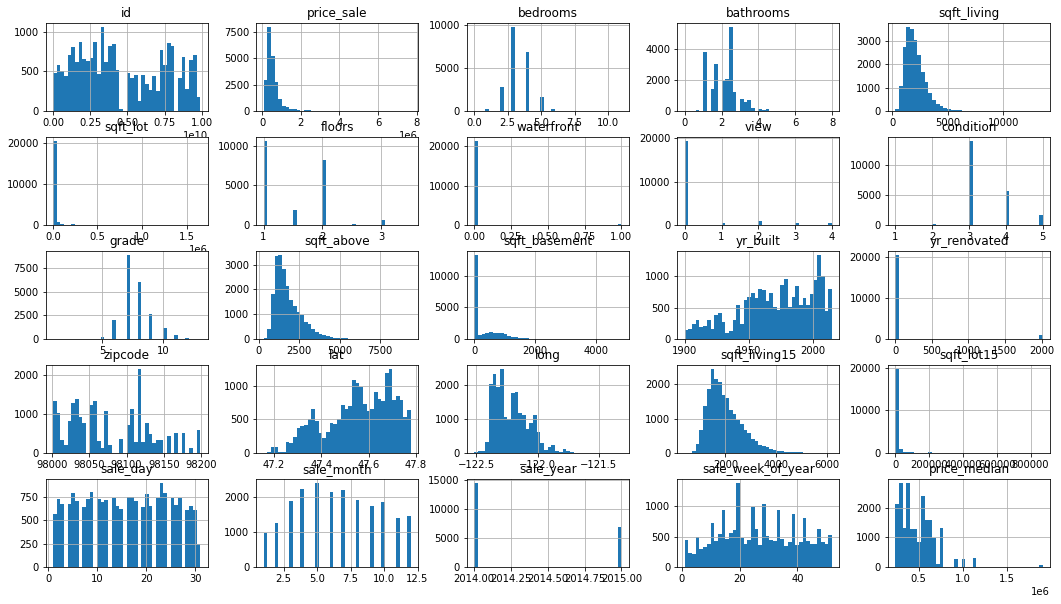

In [28]:
plt.rcParams['figure.figsize'] = [18, 10]

num_attributes_2.hist(bins=40) ;

### 4.1.2. Categorical Variable

In [29]:
df_cat('sale_day_name').T

sale_day_name,Tuesday,Wednesday,Monday,Thursday,Friday,Saturday,Sunday
absolute,4666.00,4563.00,4072.00,3969.00,3652.00,284.00,229.00
percentage,21.77,21.29,19.00,18.52,17.04,1.32,1.07


43% das vendas ocorreram entre segunda e terça-feira.

In [30]:
df_cat('holyday_sale').T

holyday_sale,No Holiday,Thanksgiving Day,Veterans Day,Christmas Eve Holiday,Memorial Day,Labor Day,Independence Day,Presidents Day
absolute,21273.00,69.00,49.00,30.00,6.00,5.00,2.00,1.00
percentage,99.24,0.32,0.23,0.14,0.03,0.02,0.01,0.00


In [31]:
df_cat('holiday_week').T

holiday_week,No,Yes
absolute,19289.00,2146.00
percentage,89.99,10.01


10% dos imóveis foram vendidos em semana de feriados.

In [32]:
df_cat('season').T

season,winter,fall,summer,spring
absolute,7986.00,5004.00,4339.00,4106.00
percentage,37.26,23.34,20.24,19.16


In [33]:
df_cat('basement').T

basement,No,Yes
absolute,13015.00,8420.00
percentage,60.72,39.28


In [34]:
df_cat('renovated').T

renovated,No,Yes
absolute,20525.00,910.00
percentage,95.75,4.25


37% dos imóveis foram vendidos no inverno.

## 4.2. Bivariate Analysis

### H1 - O ZipCode pode influenciar no valor do imóvel ?

H1 - Verdadeira, o ZipCode 98039 foram vendidos com uma média muito acima dos demais Zipcodes

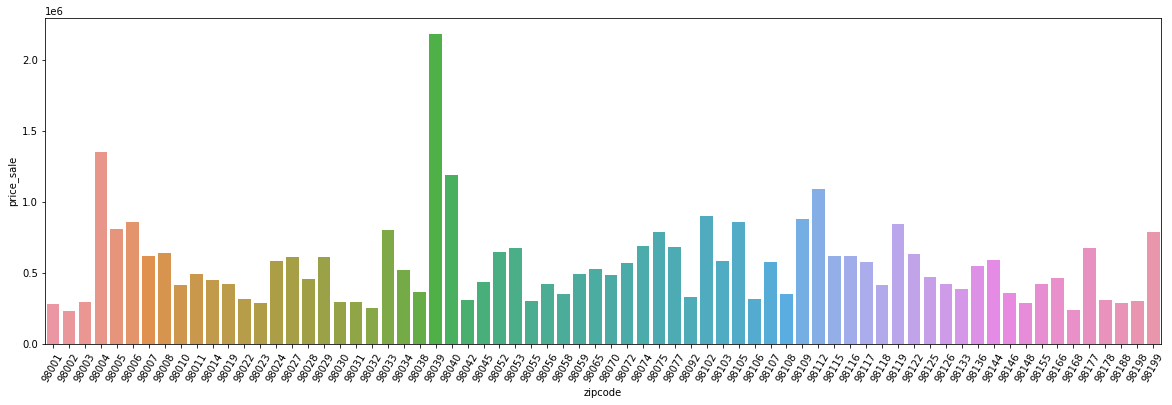

In [35]:
h1 = df4[['price_sale','zipcode']].groupby('zipcode').mean().reset_index()
plt.figure(figsize=(20,6))
sns.barplot(h1['zipcode'],h1['price_sale'])
plt.xticks(rotation=60);


### H2 -  Casas com vista privilegiada são 40% mais caras que na média ?

H2 é verdadeira, pois os imóveis com vista privilegiada são em média 61% mais caros


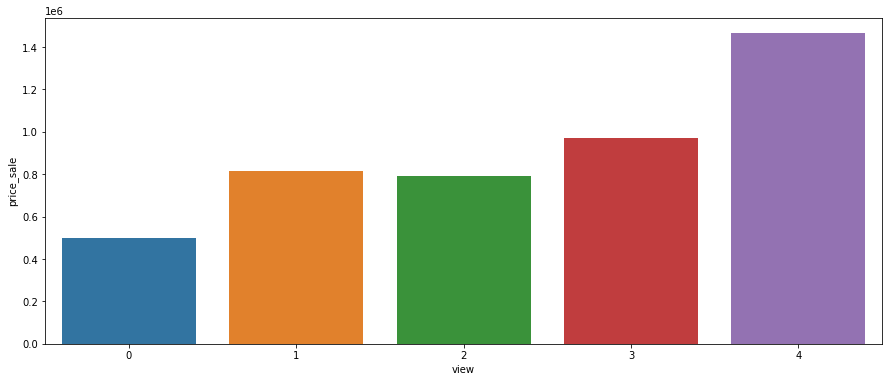

In [36]:
h2 = df4[['price_sale','view']].groupby('view').mean().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h2['view'],h2['price_sale'])

h2_percent = (h2.loc[4,'price_sale'] - h2['price_sale'].mean() ) / h2['price_sale'].mean()
print('H2 é verdadeira, pois os imóveis com vista privilegiada são em média {0:.0%} mais caros'.format(h2_percent))

### H3 - Casas com vista para a água são 50% mais caras que na média ?

H3 é verdadeira, pois os imóveis com vista para água são em média 51% mais caros


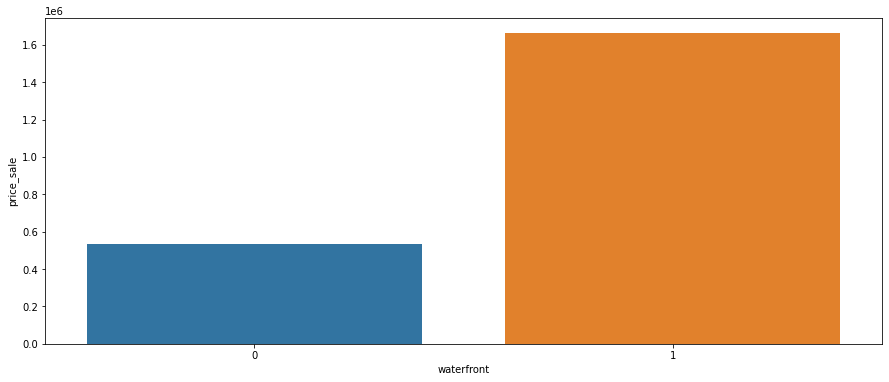

In [37]:
h3 = df4[['price_sale','waterfront']].groupby('waterfront').mean().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h3['waterfront'],h3['price_sale'])

waterfront_price = h3['price_sale'][h3['waterfront'] == 1 ].mean()
h3_percent = (waterfront_price - h3['price_sale'].mean() ) / h3['price_sale'].mean()
print('H3 é verdadeira, pois os imóveis com vista para água são em média {0:.0%} mais caros'.format(h3_percent))

### H4 - O Preço dos imóveis ficaram mais caros no decorrer dos anos YoY?

H4 Falsa, o dataset nos fornece dados de dois anos de vendas e não vemos aumento de preço conforme o passar do ano.

<AxesSubplot:xlabel='sale_year', ylabel='price_sale'>

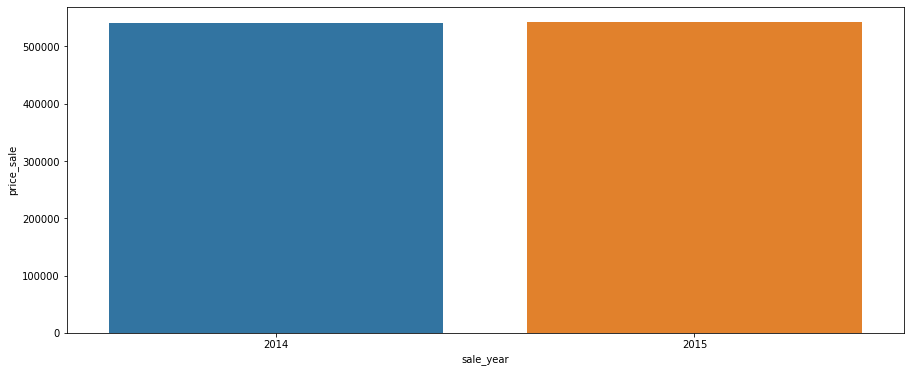

In [38]:
h4 = df4[['price_sale','sale_year']].groupby('sale_year').mean().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h4['sale_year'],h4['price_sale'])

### H5 - O dia da semana tende a influenciar na venda dos imóveis ?

H5 Verdadeira, podemos ver que no começo da semana temos uma maior incidência de vendas de imóveis.

sale_day_name,Tuesday,Wednesday,Monday,Thursday,Friday,Saturday,Sunday
absolute,4666.00,4563.00,4072.00,3969.00,3652.00,284.00,229.00
percentage,21.77,21.29,19.00,18.52,17.04,1.32,1.07


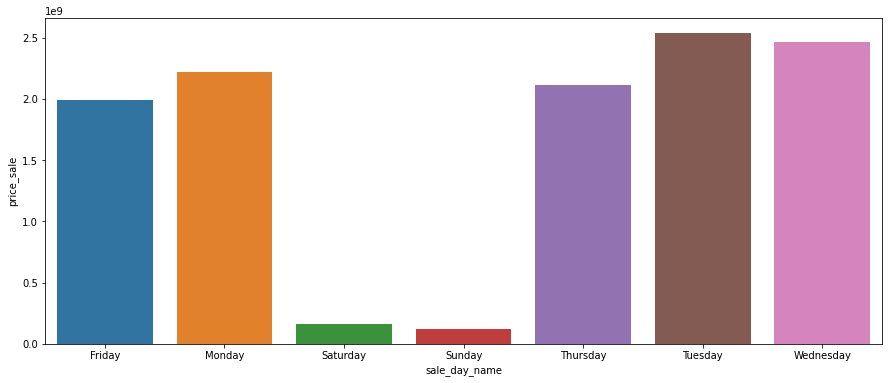

In [39]:
h5 = df4[['price_sale','sale_day_name']].groupby('sale_day_name').sum().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h5['sale_day_name'],h5['price_sale'])

df_cat('sale_day_name').T



### H6 - 7. Imóveis vendidos no inverno são 30% mais baratos do que no verão, em média ?

H1 é falsa, pois os imóveis vendidos no inverno são em média -2% mais baratos


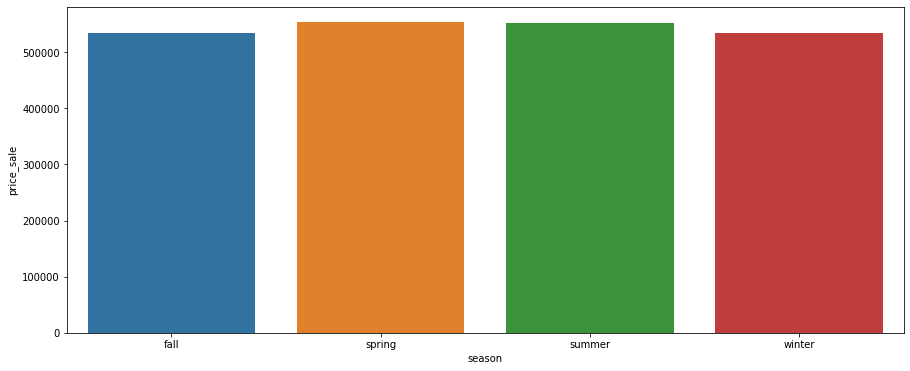

In [40]:
h6 = df4[['price_sale','season']].groupby('season').mean().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h6['season'],h6['price_sale'])

winter_price = h6['price_sale'][h6['season'] == 'winter'].mean()
h6_percent = (winter_price - h6['price_sale'].mean() ) / h6['price_sale'].mean()
print('H1 é falsa, pois os imóveis vendidos no inverno são em média {0:.0%} mais baratos'.format(h6_percent))

### H7 - Imóveis vendidos em semana de feriados são mais caros que a média, se sim quantos % são mais caros ?

H7 é verdadeira, pois os imóveis vendidos em semana de feriao são em média 2% mais caros


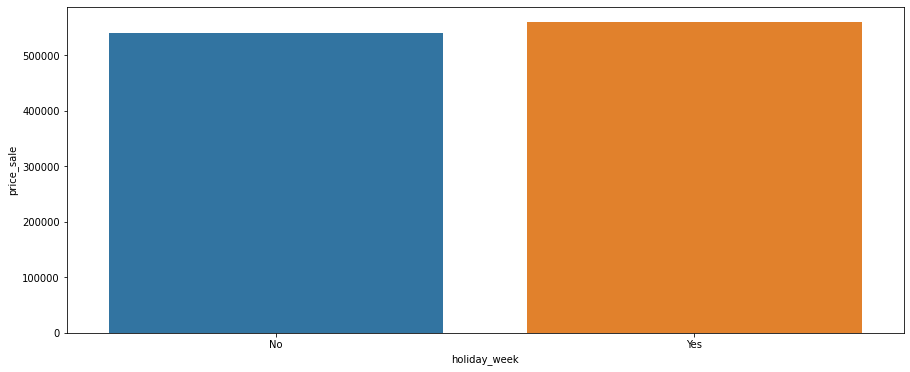

In [41]:
h7 = df4[['price_sale','holiday_week']].groupby('holiday_week').mean().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h7['holiday_week'],h7['price_sale'])

holiday_week_price = h7['price_sale'][h7['holiday_week'] == 'Yes'].mean()
h7_percent = (holiday_week_price - h7['price_sale'].mean() ) / h7['price_sale'].mean()
print('H7 é verdadeira, pois os imóveis vendidos em semana de feriao são em média {0:.0%} mais caros'.format(h7_percent))

### H8 - Imóves com mais andares são 30% mais caros ?

H8 Falsa, por mais que tenhamos números com decimais em andares, o que podemos até considrar um erro de digitação, podemos ver que imóveis com dois andares são mais caros.

<AxesSubplot:xlabel='floors', ylabel='price_sale'>

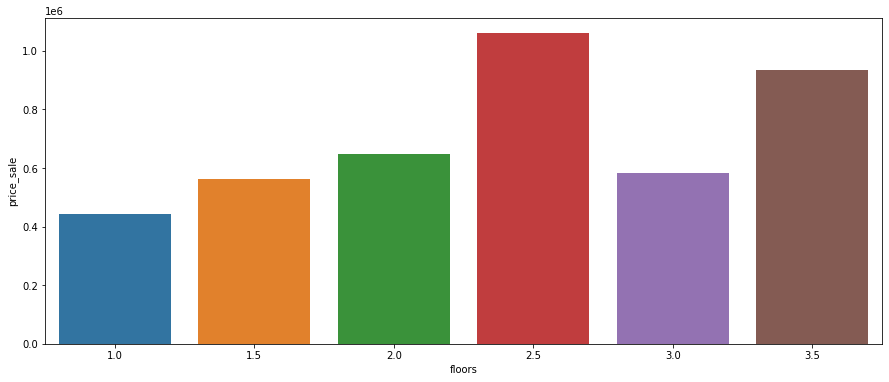

In [42]:
h8 = df4[['price_sale','floors']].groupby('floors').mean().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h8['floors'],h8['price_sale'])

### H9 - Imóveis com porão são 30% mais caros ?

H9 é falsa, pois os imóveis com porão são mais caros porém em média 12% mais caros


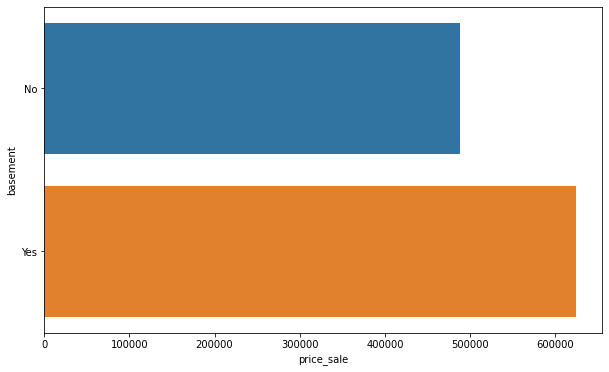

In [43]:
h9 = df4[['price_sale','basement']].groupby('basement').mean().reset_index()

plt.figure(figsize=(10,6))
sns.barplot(h9['price_sale'],h9['basement'])

basement_price = h9['price_sale'][h9['basement'] == 'Yes'].mean()
h9_percent = (basement_price - h9['price_sale'].mean() ) / h9['price_sale'].mean()
print('H9 é falsa, pois os imóveis com porão são mais caros porém em média {0:.0%} mais caros'.format(h9_percent))

### H10 Imóveis com data de contrução menor que 1970 são 30% mais baratos ?

H10 é falsa, pois os imóveis com data de construção menor que 1970 são em média -2% mais baratos


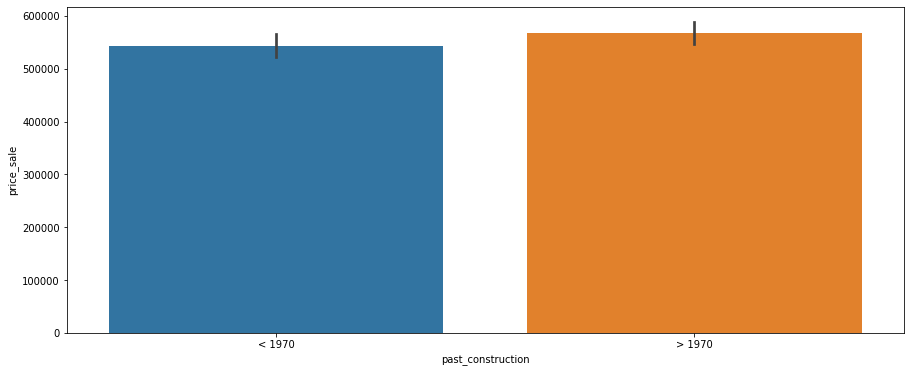

In [44]:
h10 = df4[['price_sale','yr_built']].groupby('yr_built').mean().reset_index()
h10['past_construction'] = h10['yr_built'].apply(lambda x: '> 1970' if x > 1970
        else '< 1970')

plt.figure(figsize=(15,6))
sns.barplot(h10['past_construction'],h10['price_sale'])

past_price = h10['price_sale'][h10['past_construction'] == '< 1970'].mean()
h10_percent = (past_price - h10['price_sale'].mean() ) / h10['price_sale'].mean()
print('H10 é falsa, pois os imóveis com data de construção menor que 1970 são em média {0:.0%} mais baratos'.format(h10_percent))

### H11 - Imóveis com data de reforma maior que 1980 são 50% mais caros ?

H11 é falsa, pois os imóveis com data de construção maior que 1980 são em média 6% mais caros


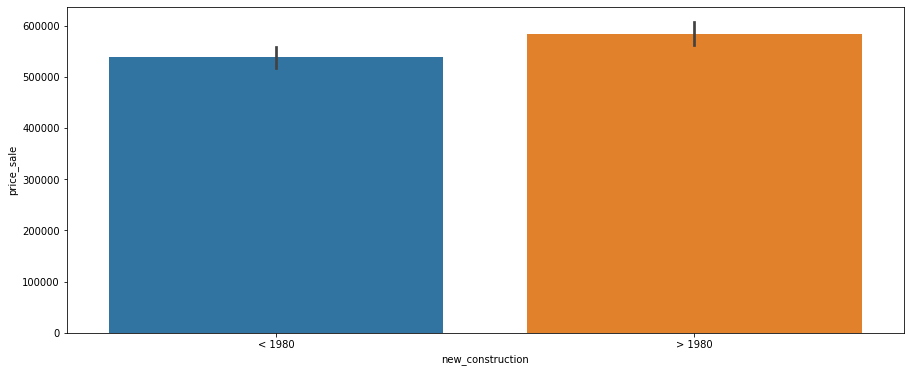

In [45]:
h11 = df4[['price_sale','yr_built']].groupby('yr_built').mean().reset_index()
h11['new_construction'] = h11['yr_built'].apply(lambda x: '> 1980' if x >= 1980
        else '< 1980')

plt.figure(figsize=(15,6))
sns.barplot(h11['new_construction'],h11['price_sale'])

new_price = h11['price_sale'][h11['new_construction'] == '> 1980'].mean()
h11_percent = (new_price - h11['price_sale'].mean() ) / h11['price_sale'].mean()
print('H11 é falsa, pois os imóveis com data de construção maior que 1980 são em média {0:.0%} mais caros'.format(h11_percent))

### H12 - Imóveis com maior número de quarto são 40% mais caros ?

H12 é verdadeira, notamos graficamente que casa com 8 quartos tiveram preços 63% maiores na média e verificamos que maior que 8 quartos tem uma tendência de queda nos preços.


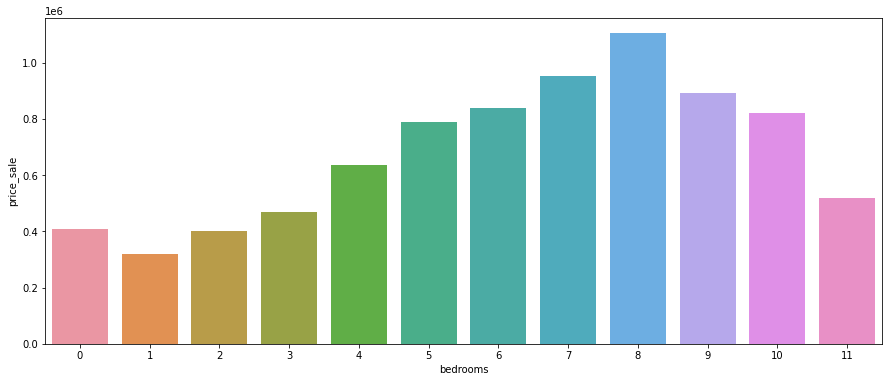

In [46]:
h12 = df4[['price_sale','bedrooms']].groupby('bedrooms').mean().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h12['bedrooms'],h12['price_sale'])

bedroom_price = h12['price_sale'][h12['bedrooms'] == 8].mean()
h12_percent = (bedroom_price - h12['price_sale'].mean() ) / h12['price_sale'].mean()
print('H12 é verdadeira, notamos graficamente que casa com 8 quartos tiveram preços {0:.0%} maiores na média e verificamos que maior que 8 quartos tem uma tendência de queda nos preços.'.format(h12_percent))

### H13 - Imóveis com maior número de banheiros são 40% mais caros ?

H13 é verdadeira, notamos graficamente que casa com 7 e 8 banheiros tiveram preços 223% maiores na média, talvez tambḿ um possível outlier esses valores, mas vmos uma tendência de alta nos preços, conforme maior o número de quartos.


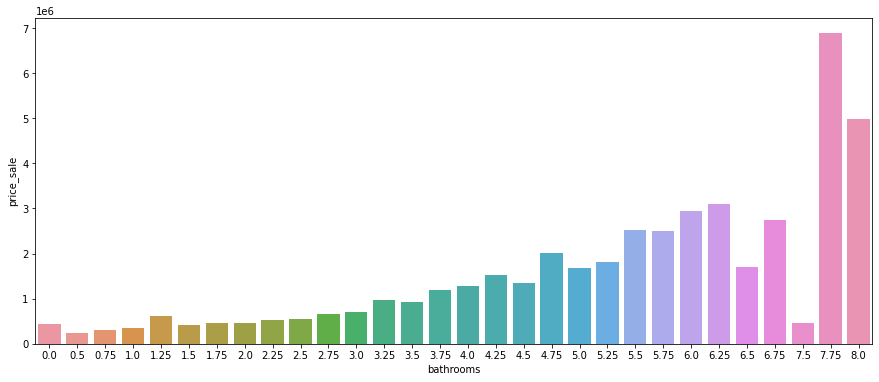

In [47]:
h13 = df4[['price_sale','bathrooms']].groupby('bathrooms').mean().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h13['bathrooms'],h13['price_sale'])

bathroom_price = h13['price_sale'][h13['bathrooms'] == 8].mean()
h13_percent = (bathroom_price - h13['price_sale'].mean() ) / h13['price_sale'].mean()
print('H13 é verdadeira, notamos graficamente que casa com 7 e 8 banheiros tiveram preços {0:.0%} maiores na média, talvez tambḿ um possível outlier esses valores, mas vmos uma tendência de alta nos preços, conforme maior o número de quartos.'.format(h13_percent))

### H14 - Casas em condições muito boas são 60% mais caras, na média ?

H14 é falsa, imovéis em condições muito boas são em média 30% mais caros


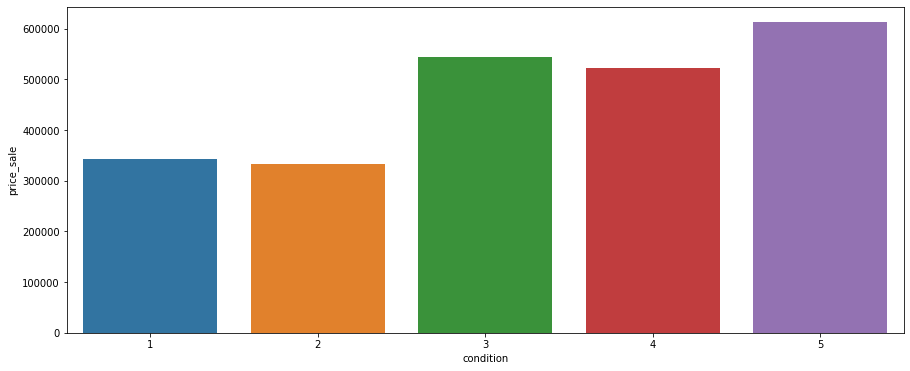

In [48]:
h14 = df4[['price_sale','condition']].groupby('condition').mean().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h14['condition'],h14['price_sale'])

condition_price = h14['price_sale'][h14['condition'] == 5].mean()
h14_percent = (condition_price - h14['price_sale'].mean() ) / h14['price_sale'].mean()
print('H14 é falsa, imovéis em condições muito boas são em média {0:.0%} mais caros'.format(h14_percent))

### H15 - Casa em condições fracas são 60% mais baratas, na média ?

H15 é falsa, imovéis em condições fraca são em média -27% mais baratos


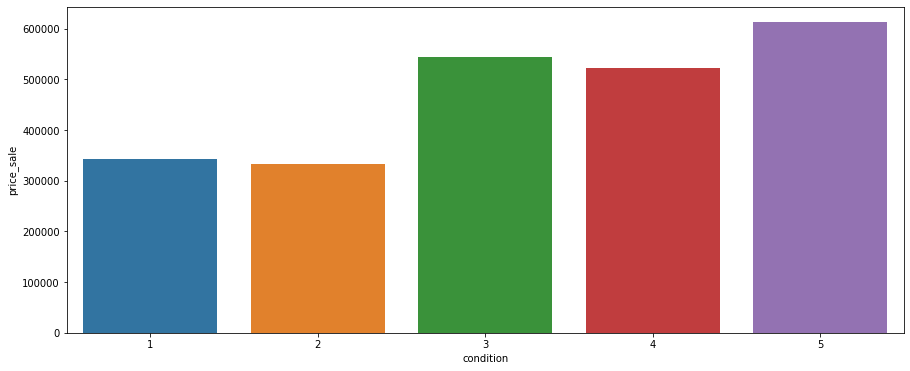

In [49]:
h15 = df4[['price_sale','condition']].groupby('condition').mean().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h15['condition'],h14['price_sale'])

condition_price_bad = h15['price_sale'][h15['condition'] == 1].mean()
h15_percent = (condition_price_bad - h15['price_sale'].mean() ) / h15['price_sale'].mean()
print('H15 é falsa, imovéis em condições fraca são em média {0:.0%} mais baratos'.format(h15_percent))

### H16 - Casas que foram reformadas tendem a terem os preços mais altos.?

H16 é verdadeira pois os imóveis reformados são 18% mais caros


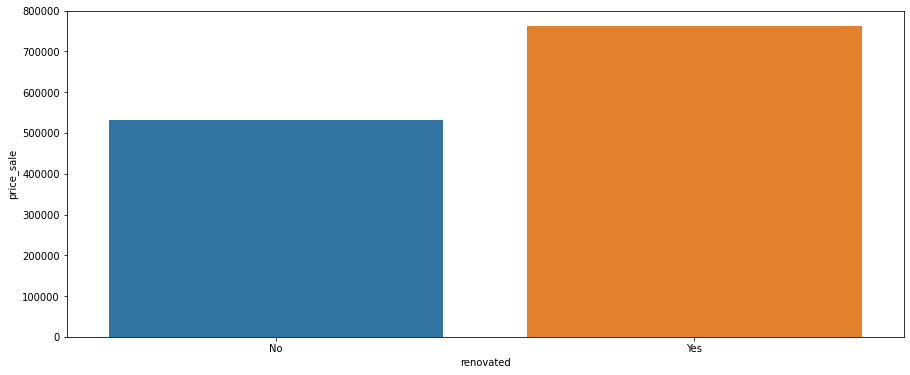

In [50]:
h16 = df4[['price_sale','renovated']].groupby('renovated').mean().reset_index()
plt.figure(figsize=(15,6))
sns.barplot(h16['renovated'],h16['price_sale'])

renovated_price = h16['price_sale'][h16['renovated'] == 'Yes'].mean()
h16_percent = (renovated_price - h16['price_sale'].mean() ) / h16['price_sale'].mean()
print('H16 é verdadeira pois os imóveis reformados são {0:.0%} mais caros'.format(h16_percent))

<AxesSubplot:title={'center':'Condition by Bedrooms'}, xlabel='renovated'>

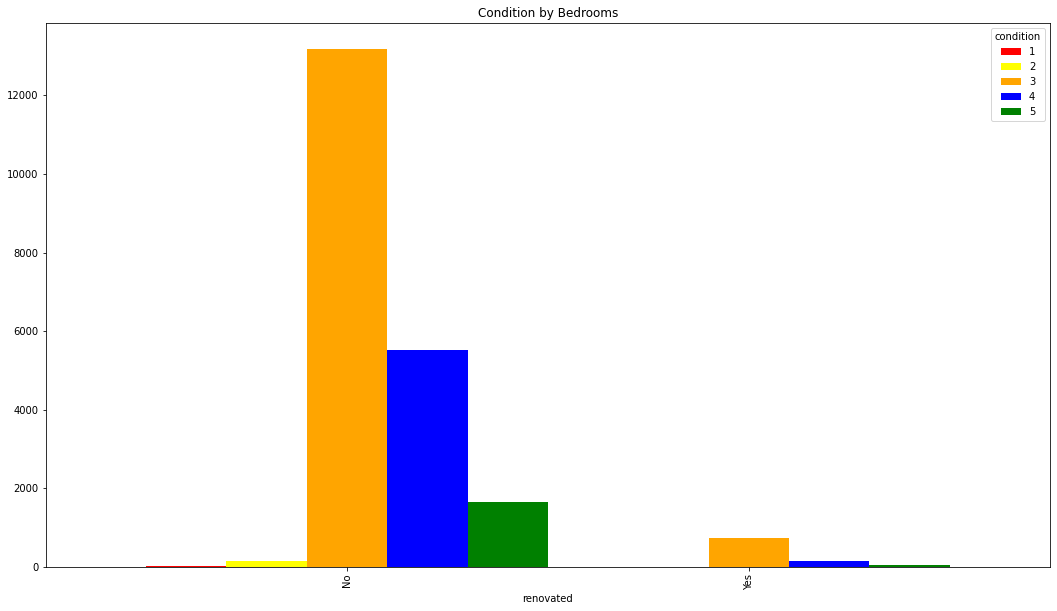

In [51]:
table = pd.crosstab(df4['renovated'],df4['condition'])
table.plot(kind='bar',width=1.0, color=['red','yellow','orange','blue','green'], title='Condition by Bedrooms' ,grid=False)

Com base nas informaçõs do primeiro gráfico no qual os imóveis reformados são cerca de 18% mais caros. Fazendo uma tabela cruzada de reforma x condição, podemos que a maioria dos imóveis reformador tem a condição 3, seguida das condições 4 e 5, e podemos ver que praticamente não temos imoveis reformados com condições baixas.

### H17 - Casas com menor grau de construção, são 50 % mais baratas, na média ?

H17 é verdadeira pois as casas com menor grau de construção são -69% mais baratas


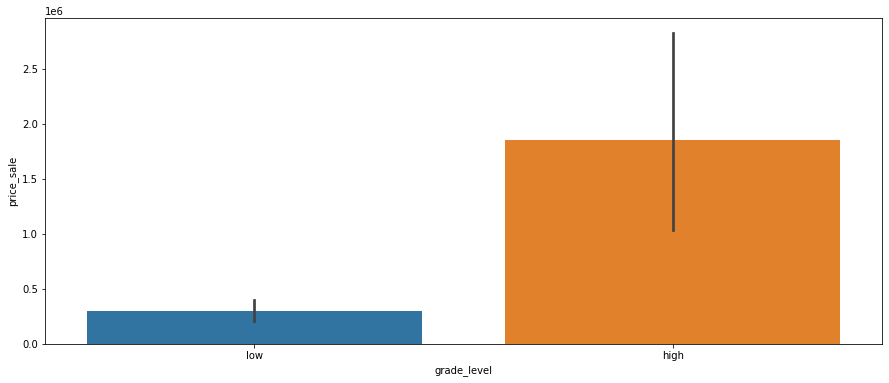

In [52]:
h17 = df4[['price_sale','grade']].groupby('grade').mean().reset_index()
h17['grade_level'] = h17['grade'].apply( lambda x: 'high' if x >= 9 else 'low' )
plt.figure(figsize=(15,6))
sns.barplot(h17['grade_level'],h17['price_sale'])

grade_price = h17['price_sale'][h17['grade_level'] == 'low'].mean()
h17_percent = (grade_price - h17['price_sale'].mean() ) / h17['price_sale'].mean()
print('H17 é verdadeira pois as casas com menor grau de construção são {0:.0%} mais baratas'.format(h17_percent))

# 5 - Business Issues

In [53]:
df5 = df4.copy()

In [54]:
df5.head()

,id,price_sale,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,sale_day,sale_month,sale_year,sale_week_of_year,sale_day_name,holyday_sale,holiday_week,season,price_median
0,7129300520,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,No,No,13,10,2014,42,Monday,No Holiday,No,fall,279500.00
1,4060000240,205425.00,2,1.00,880,6780,1.00,0,0,4,6,880,0,1945,0,98178,47.50,-122.25,1190,6780,No,No,23,6,2014,26,Monday,No Holiday,No,summer,279500.00
2,4058801670,445000.00,3,2.25,2100,8201,1.00,0,2,3,8,1620,480,1967,0,98178,47.51,-122.24,2660,8712,Yes,No,17,7,2014,29,Thursday,No Holiday,No,summer,279500.00
3,2976800796,236000.00,3,1.00,1300,5898,1.00,0,0,3,7,1300,0,1961,0,98178,47.51,-122.25,1320,7619,No,No,25,9,2014,39,Thursday,No Holiday,No,fall,279500.00
4,6874200960,170000.00,2,1.00,860,5265,1.00,0,0,3,6,860,0,1931,0,98178,47.50,-122.27,1650,8775,No,No,27,2,2015,9,Friday,No Holiday,No,winter,279500.00


## 5.1 - Quais casas o CEO da House Rocket deveria comprar e por qual preço de compra?

In [55]:
# criando uma coluna de percentual do preço de venda da mediana, o quão mais cara ou mais barata ela está.

df5['percent_diff_price_median']= ((df5['price_sale'] - df5['price_median']) / df5['price_sale']) * 100

Conforme em análise em hipóteses anteriores, pudemos verificar que a maioria dos imóveis que foram reformados estavam com nota acima de 3 nas condições, pensando em um possível custo de reforma nesses imóveis para melhorar suas condições e obtermos um lucro, vamos avaliar para uma avaliação de compra da casas, imóveis que estejam 15% abaixo da mediana de cada zipcode e com condições acima de 2.

In [56]:
# criar uma coluna status no dataset,  buscando todos os imóveis que estão com preço de venda 
#15% abaixo da mediana.

for i in range(len(df5)):
    
    if (df5.loc[i,'percent_diff_price_median'] <= -15) & (df5.loc[i,'condition'] >= 2):
        df5.loc[i,'action'] = 'buy'
    
    else:
        df5.loc[i,'action'] = 'no buy'

In [57]:
df5.sample(10)

,id,price_sale,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,sale_day,sale_month,sale_year,sale_week_of_year,sale_day_name,holyday_sale,holiday_week,season,price_median,percent_diff_price_median,action
5668,1450100390,208000.00,3,1.00,920,7314,1.00,0,0,3,6,920,0,1960,0,98002,47.29,-122.22,1010,7420,No,No,16,3,2015,12,Monday,No Holiday,No,spring,235000.00,-12.98,no buy
12722,5045700090,480000.00,5,2.75,2670,4780,2.00,0,0,3,8,2670,0,2013,0,98059,47.49,-122.16,2560,5380,No,No,6,1,2015,2,Tuesday,No Holiday,No,winter,435000.00,9.38,no buy
3606,7920100045,350000.00,1,1.00,700,5100,1.00,0,0,3,7,700,0,1942,0,98115,47.68,-122.30,1010,5100,No,No,16,5,2014,20,Friday,No Holiday,No,winter,570000.00,-62.86,buy
13385,1250200693,515000.00,3,3.00,2100,2409,2.00,0,0,3,8,1660,440,2008,0,98144,47.60,-122.30,1900,2400,Yes,No,18,7,2014,29,Friday,No Holiday,No,summer,452500.00,12.14,no buy
15635,8101900100,310000.00,3,1.00,1510,6000,1.00,0,0,3,8,1170,340,1953,0,98118,47.52,-122.28,1125,6000,Yes,No,28,3,2015,13,Saturday,No Holiday,No,spring,370000.00,-19.35,buy
12154,686400210,525000.00,4,2.25,1890,8549,1.00,0,0,3,8,1890,0,1967,0,98008,47.63,-122.12,1940,7210,No,No,22,9,2014,39,Monday,No Holiday,No,fall,545000.00,-3.81,no buy
20937,42000065,355000.00,2,1.00,1450,9150,1.00,0,0,4,7,1450,0,1965,0,98188,47.47,-122.28,1440,10636,No,No,5,3,2015,10,Thursday,No Holiday,No,spring,265000.00,25.35,no buy
6154,217700050,395000.00,3,2.25,1780,9672,1.00,0,0,3,8,1350,430,1960,0,98133,47.78,-122.35,1860,10080,Yes,No,30,10,2014,44,Thursday,No Holiday,No,fall,375000.00,5.06,no buy
14356,7016300050,420000.00,4,2.50,2030,8100,1.00,0,0,3,7,1150,880,1973,0,98034,47.74,-122.19,1770,8071,Yes,No,23,7,2014,30,Wednesday,No Holiday,No,summer,446000.00,-6.19,no buy
7095,9414700020,331000.00,4,3.00,2483,5701,2.00,0,0,3,8,2483,0,2005,0,98030,47.36,-122.20,2075,5720,No,No,22,4,2015,17,Wednesday,No Holiday,No,spring,283000.00,14.50,no buy


In [58]:
# Verificando o total de casas
total_houses = df5.loc[df5['action'] == 'buy'].shape[0]

print('Foram encontrados {} imóveis dentro das condições acima, sugeridos para compra'.format(total_houses))


Foram encontrados 6728 imóveis dentro das condições acima, sugeridos para compra


## 5.2 - Uma vez a casa em posse da empresa, qual o melhor momento para vendê-las e qual seria o preço da venda?

De acordo com a análise da hipótese 6 da análise dos dados, não temos nenhuma diferença grande no valor de venda de casas pela estação do ano. Não podemos considerar uma condição de aumento de valors por estação.

Com as informações atuais em mãos vamos criar abaixo uma varivável sales_suggstion com uma meta de ganho de 20% em relação aos imóveis adquiridos que estejam em condições acima de 3, e para os imóveis com condições acima de 2 vamos sugerir um ganho de 13%. 

In [59]:
for i in range(len(df5)):
    
    if (df5.loc[i,'price_sale'] < df5.loc[i,'price_median']) & (df5.loc[i,'condition'] <= 2):
        df5.loc[i,'sales_suggestion'] = df5.loc[i,'price_sale']*1.20
    
    if (df5.loc[i,'price_sale'] < df5.loc[i,'price_median']) & (df5.loc[i,'condition'] >= 3):
        df5.loc[i,'sales_suggestion'] = df5.loc[i,'price_sale']*1.30
    
    else:
        df5.loc[i,'sales_suggestion'] = df5.loc[i,'price_sale']*1.30

No segundo processo da pergunta, com as datas e períodos que temos no dataframe, vamos vrificar qual a melhor temporaa para vendas, comparando as medianas de cada etação do ano por zipcode, qual a estação que tve a maior mediana por cada Zipcode, e vamos considera-la como a melhor temporada para vndas.

In [60]:
# median buying price by zipcode and season

d = df5[['price_sale','zipcode','season']].groupby(['zipcode', 'season']).median().reset_index()
d.head()


,zipcode,season,price_sale
0,98001,fall,249950.00
1,98001,spring,285825.50
2,98001,summer,263000.00
3,98001,winter,258950.00
4,98002,fall,235000.00


In [61]:
b = d.pivot(index='zipcode', columns='season', values='price_sale').reset_index()
b = b.rename(columns={'fall':'med_fall', 'spring':'med_spring', 'summer':'med_summer', 'winter':'med_winter'})
b.head()

season,zipcode,med_fall,med_spring,med_summer,med_winter
0,98001,249950.00,285825.50,263000.00,258950.00
1,98002,235000.00,235000.00,227500.00,242000.00
2,98003,255000.00,275000.00,259250.00,284025.00
3,98004,980000.00,1388000.00,1100000.00,1149000.00
4,98005,813000.00,781225.00,745000.00,738950.00


In [62]:
b['max_value'] = b.max(axis=1)

In [63]:

for i in range (len(b)):
    if (b.loc[i,'med_fall'] == b.loc[i,'max_value']):
        b.loc[i,'best_season_for_sale'] = 'fall'
    elif (b.loc[i,'med_spring'] == b.loc[i,'max_value']):
        b.loc[i,'best_season_for_sale'] = 'spring'
    elif (b.loc[i,'med_summer'] == b.loc[i,'max_value']):
        b.loc[i,'best_season_for_sale'] = 'summer'    
    elif (b.loc[i,'med_winter'] == b.loc[i,'max_value']):
        b.loc[i,'best_season_for_sale'] = 'winter'    

In [64]:
b.head()

season,zipcode,med_fall,med_spring,med_summer,med_winter,max_value,best_season_for_sale
0,98001,249950.00,285825.50,263000.00,258950.00,285825.50,spring
1,98002,235000.00,235000.00,227500.00,242000.00,242000.00,winter
2,98003,255000.00,275000.00,259250.00,284025.00,284025.00,winter
3,98004,980000.00,1388000.00,1100000.00,1149000.00,1388000.00,spring
4,98005,813000.00,781225.00,745000.00,738950.00,813000.00,fall


In [65]:
# incorporando a variável best time for sale ao dataset.

#df5['best_season_for_sale'] = b['best_time_for_sale']

df5 = pd.merge(df5, b, how ='left', on='zipcode')
df5 = df5.drop(['med_fall','med_spring' , 'med_summer', 'med_winter', 'max_value'], axis=1)

In [66]:
df5.head(1000)

,id,price_sale,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,sale_day,sale_month,sale_year,sale_week_of_year,sale_day_name,holyday_sale,holiday_week,season,price_median,percent_diff_price_median,action,sales_suggestion,best_season_for_sale
0,7129300520,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,No,No,13,10,2014,42,Monday,No Holiday,No,fall,279500.00,-25.96,buy,288470.00,fall
1,4060000240,205425.00,2,1.00,880,6780,1.00,0,0,4,6,880,0,1945,0,98178,47.50,-122.25,1190,6780,No,No,23,6,2014,26,Monday,No Holiday,No,summer,279500.00,-36.06,buy,267052.50,fall
2,4058801670,445000.00,3,2.25,2100,8201,1.00,0,2,3,8,1620,480,1967,0,98178,47.51,-122.24,2660,8712,Yes,No,17,7,2014,29,Thursday,No Holiday,No,summer,279500.00,37.19,no buy,578500.00,fall
3,2976800796,236000.00,3,1.00,1300,5898,1.00,0,0,3,7,1300,0,1961,0,98178,47.51,-122.25,1320,7619,No,No,25,9,2014,39,Thursday,No Holiday,No,fall,279500.00,-18.43,buy,306800.00,fall
4,6874200960,170000.00,2,1.00,860,5265,1.00,0,0,3,6,860,0,1931,0,98178,47.50,-122.27,1650,8775,No,No,27,2,2015,9,Friday,No Holiday,No,winter,279500.00,-64.41,buy,221000.00,fall
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
995,4318200090,375000.00,2,1.00,940,9839,1.00,0,0,3,6,940,0,1910,0,98136,47.54,-122.39,1330,8740,No,No,18,6,2014,25,Wednesday,No Holiday,No,summer,489950.00,-30.65,buy,487500.00,spring
996,2719100042,458500.00,3,2.00,1890,1599,2.00,0,0,3,9,1430,460,2012,0,98136,47.54,-122.39,1780,1562,Yes,No,23,6,2014,26,Monday,No Holiday,No,summer,489950.00,-6.86,no buy,596050.00,spring
997,2461900375,685000.00,4,2.50,2770,6000,2.00,0,0,3,8,2400,370,1993,0,98136,47.55,-122.38,2120,6000,Yes,No,14,4,2015,16,Tuesday,No Holiday,No,spring,489950.00,28.47,no buy,890500.00,spring
998,3013300017,535000.00,3,1.00,1290,6859,1.00,0,0,4,7,1290,0,1941,0,98136,47.53,-122.39,1560,6369,No,No,8,4,2015,15,Wednesday,No Holiday,No,spring,489950.00,8.42,no buy,695500.00,spring


## 5.3 - A House Rocket deveria fazer uma reforma para aumentar o preço da venda? Quais seriam as sugestões de mudanças? Qual o incremento no preço dado por cada opção de reforma?¶

### 5.3.1 - Verificando correlações

Uma vez definido quais casas estão no radar de compra, vamos verificar abaixo, quais variáveis, tem forte correlação com o preço do imóvel.

- 0.00 a 0.19: Correlação muito fraca

- 0.20 a 0.39: Correlação fraca

- 0.40 a 0.69: Correlação moderada

- 0.70 a 0.89: Correlação forte

- 0.90 a 1.00: Correlação muito forte

<AxesSubplot:title={'center':'Correlação de Pearson'}>

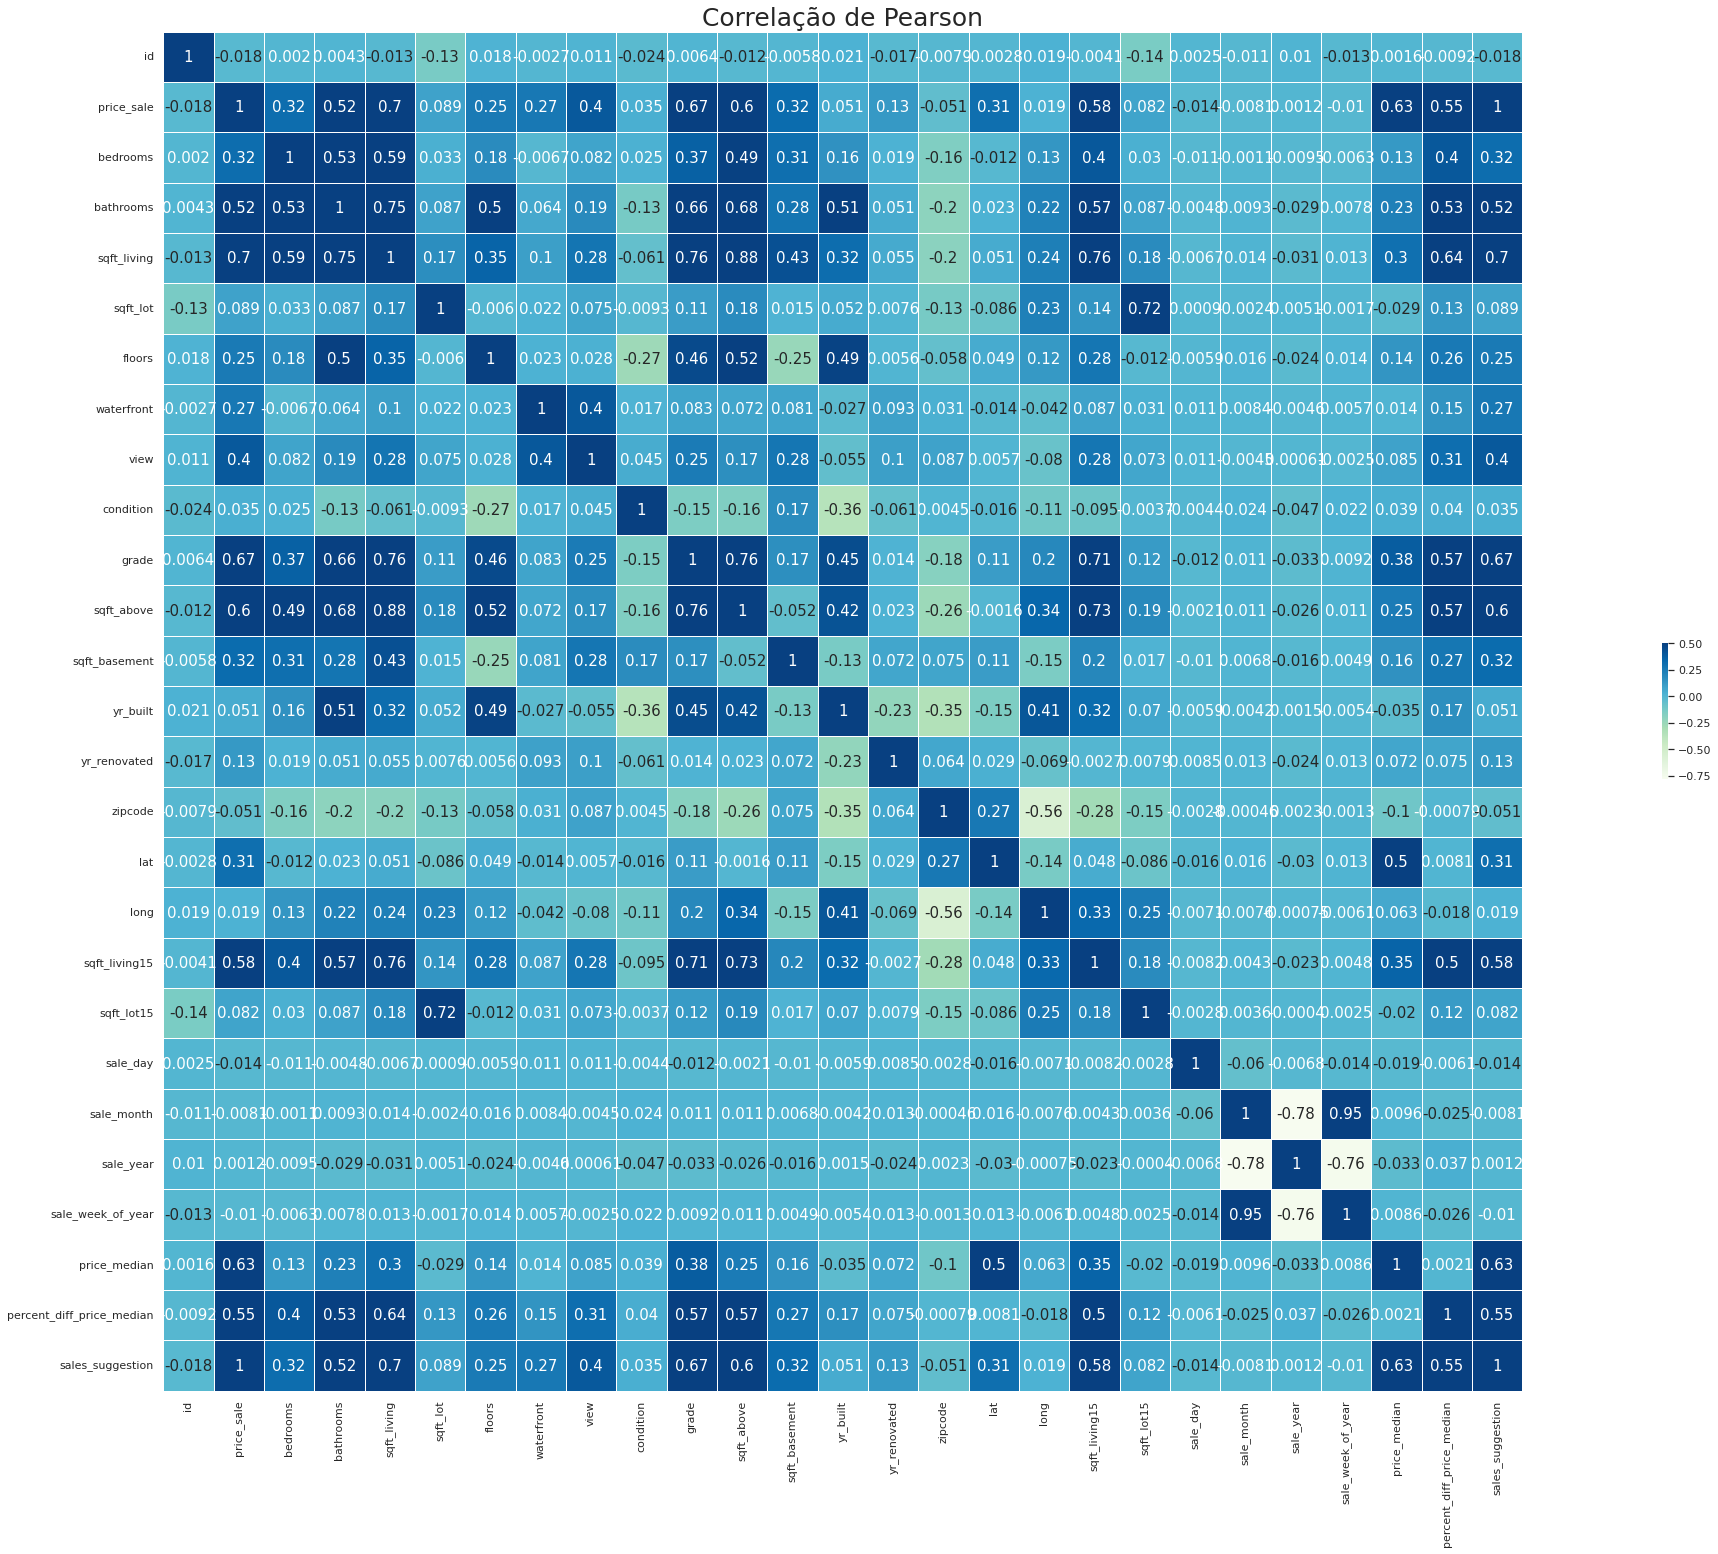

In [67]:
# House Rocket - Comparando imóveis

sns.set(style="whitegrid", font_scale=1)

plt.figure(figsize=(50,25))
plt.title('Correlação de Pearson',fontsize=25)
sns.heatmap(df5.corr(),linewidths=1,vmax=0.50,square=True,cmap="GnBu",linecolor='w',
            annot=True, annot_kws={"size":15}, cbar_kws={"shrink": .10})

Conseguimos verificar identificar que 5 variáveis possuem um forte correlação com o preço:
sqft_living, grade,sqft_above , sqft_living15, bathrooms.            


In [68]:
# plotando as correlações em ordem descrescente.

price_corr = df5.corr()['price_sale'].sort_values(ascending=False)
print(price_corr)

price_sale                   1.00
sales_suggestion             1.00
sqft_living                  0.70
grade                        0.67
price_median                 0.63
sqft_above                   0.60
sqft_living15                0.58
percent_diff_price_median    0.55
bathrooms                    0.52
view                         0.40
sqft_basement                0.32
bedrooms                     0.32
lat                          0.31
waterfront                   0.27
floors                       0.25
yr_renovated                 0.13
sqft_lot                     0.09
sqft_lot15                   0.08
yr_built                     0.05
condition                    0.03
long                         0.02
sale_year                    0.00
sale_month                  -0.01
sale_week_of_year           -0.01
sale_day                    -0.01
id                          -0.02
zipcode                     -0.05
Name: price_sale, dtype: float64


In [69]:
# variáveis categóricas.


a = df5.select_dtypes( include='object' )
a['price'] = df5['price_sale']
a

,basement,renovated,sale_day_name,holyday_sale,holiday_week,season,action,best_season_for_sale,price
0,No,No,Monday,No Holiday,No,fall,buy,fall,221900.00
1,No,No,Monday,No Holiday,No,summer,buy,fall,205425.00
2,Yes,No,Thursday,No Holiday,No,summer,no buy,fall,445000.00
3,No,No,Thursday,No Holiday,No,fall,buy,fall,236000.00
4,No,No,Friday,No Holiday,No,winter,buy,fall,170000.00
...,...,...,...,...,...,...,...,...,...
21430,No,No,Friday,No Holiday,No,fall,no buy,fall,2720000.00
21431,No,No,Friday,No Holiday,No,summer,no buy,fall,1950000.00
21432,No,No,Tuesday,No Holiday,No,spring,no buy,fall,2250000.00
21433,No,No,Thursday,No Holiday,Yes,fall,no buy,fall,2900000.00


<AxesSubplot:>

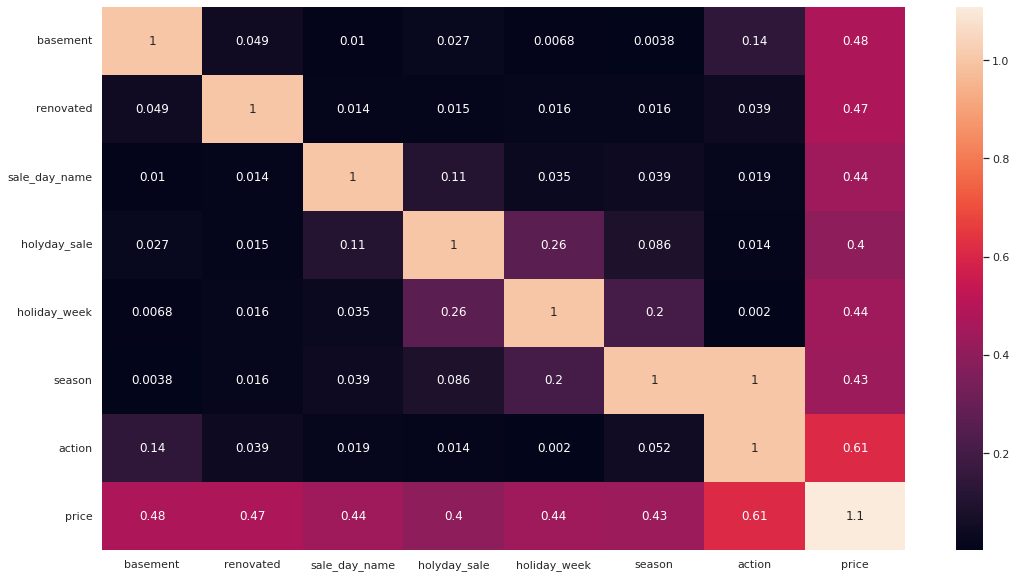

In [70]:
# Calculate cramer V
a1 = cramer_v( a['basement'], a['basement'] )
a2 = cramer_v( a['basement'], a['renovated'] )
a3 = cramer_v( a['basement'], a['sale_day_name'] )
a4 = cramer_v( a['basement'], a['holyday_sale'] )
a5 = cramer_v( a['basement'], a['holiday_week'] )
a6 = cramer_v( a['basement'], a['season'] )
a7 = cramer_v( a['basement'], a['action'] )
b1 = cramer_v( a['basement'], a['price'] )

a8 = cramer_v( a['renovated'], a['basement'] )
a9 = cramer_v( a['renovated'], a['renovated'] )
a10 = cramer_v( a['renovated'], a['sale_day_name'] )
a11 = cramer_v( a['renovated'], a['holyday_sale'] )
a12 = cramer_v( a['renovated'], a['holiday_week'] )
a13 = cramer_v( a['renovated'], a['season'] )
a14 = cramer_v( a['renovated'], a['action'] )
b2 = cramer_v( a['renovated'], a['price'] )

a15 = cramer_v( a['sale_day_name'], a['basement'] )
a16 = cramer_v( a['sale_day_name'], a['renovated'] )
a17 = cramer_v( a['sale_day_name'], a['sale_day_name'] )
a18 = cramer_v( a['sale_day_name'], a['holyday_sale'] )
a19 = cramer_v( a['sale_day_name'], a['holiday_week'] )
a20 = cramer_v( a['sale_day_name'], a['season'] )
a21 = cramer_v( a['sale_day_name'], a['action'] )
b3 = cramer_v( a['sale_day_name'], a['price'] )

a22 = cramer_v( a['holyday_sale'], a['basement'] )
a23 = cramer_v( a['holyday_sale'], a['renovated'] )
a24 = cramer_v( a['holyday_sale'], a['sale_day_name'] )
a25 = cramer_v( a['holyday_sale'], a['holyday_sale'] )
a26 = cramer_v( a['holyday_sale'], a['holiday_week'] )
a27 = cramer_v( a['holyday_sale'], a['season'] )
a28 = cramer_v( a['holyday_sale'], a['action'] )
b4 = cramer_v( a['holyday_sale'], a['price'] )

a29 = cramer_v( a['holiday_week'], a['basement'] )
a30 = cramer_v( a['holiday_week'], a['renovated'] )
a31 = cramer_v( a['holiday_week'], a['sale_day_name'] )
a32 = cramer_v( a['holiday_week'], a['holyday_sale'] )
a33 = cramer_v( a['holiday_week'], a['holiday_week'] )
a34 = cramer_v( a['holiday_week'], a['season'] )
a35 = cramer_v( a['holiday_week'], a['action'] )
b5 = cramer_v( a['holiday_week'], a['price'] )

a36 = cramer_v( a['season'], a['basement'] )
a37 = cramer_v( a['season'], a['renovated'] )
a38 = cramer_v( a['season'], a['sale_day_name'] )
a39 = cramer_v( a['season'], a['holyday_sale'] )
a40 = cramer_v( a['season'], a['holiday_week'] )
a41 = cramer_v( a['season'], a['season'] )
a42 = cramer_v( a['season'], a['action'] )
b6 = cramer_v( a['season'], a['price'] )

a43 = cramer_v( a['action'], a['basement'] )
a44 = cramer_v( a['action'], a['renovated'] )
a45 = cramer_v( a['action'], a['sale_day_name'] )
a46 = cramer_v( a['action'], a['holyday_sale'] )
a47 = cramer_v( a['action'], a['holiday_week'] )
a48 = cramer_v( a['action'], a['season'] )
a49 = cramer_v( a['action'], a['action'] )
b7 = cramer_v( a['action'], a['price'] )

a50 = cramer_v( a['price'], a['basement'] )
a51 = cramer_v( a['price'], a['renovated'] )
a52 = cramer_v( a['price'], a['sale_day_name'] )
a53 = cramer_v( a['price'], a['holyday_sale'] )
a54 = cramer_v( a['price'], a['holiday_week'] )
a55 = cramer_v( a['price'], a['season'] )
a56 = cramer_v( a['price'], a['action'] )
b8 = cramer_v( a['price'], a['price'] )

# Final dataset
d = pd.DataFrame( {'basement': [a1, a2, a3, a4, a5, a6, a7, b1], 
                   'renovated': [a8, a9, a10, a11, a12, a13, a14, b2],
                   'sale_day_name': [a15, a16, a17, a18, a19, a20, a21, b3],
                   'holyday_sale' : [a22, a23, a24, a25, a26, a27, a28, b4],
                   'holiday_week' : [a29, a30, a31, a32, a33, a34, a35, b5],
                   'season': [a36, a37, a38, a39, a40, a41, a42, b6],
                   'action': [a43, a44, a45, a46, a47, a49, a49, b7],
                    'price':[a50, a51, a52, a53, a54, a55, a56, b8] })
d = d.set_index( d.columns )

sns.heatmap( d, annot=True )

Pudemos verificar algumas variáveis categóricas, com uma correlação moderada com a variáveis preço.

basement, renovated, holiday_week, season.

De acordo com a variável percent_diff_price_median, vamos criar grupos de casas para verificarmos as características de cadas grupo e assim, verificarmos qual incremento podemos fazr em cada casa.

In [71]:
g = df5

In [72]:
for i in range(len(g)):
    
    if (g.loc[i,'percent_diff_price_median'] <= -40) & (g.loc[i,'percent_diff_price_median'] >= -450):

        g.loc[i,'group'] = 1
    
    elif (g.loc[i,'percent_diff_price_median'] <= -30) & (g.loc[i,'percent_diff_price_median'] >= -40):

        g.loc[i,'group'] = 2
        
        
    elif (g.loc[i,'percent_diff_price_median'] <= -20) & (g.loc[i,'percent_diff_price_median'] >= -30):

        g.loc[i,'group'] = 3   
        
        
    elif (g.loc[i,'percent_diff_price_median'] <= -10) & (g.loc[i,'percent_diff_price_median'] >= -20):

        g.loc[i,'group'] = 4   
        
    elif (g.loc[i,'percent_diff_price_median'] <= 0) & (g.loc[i,'percent_diff_price_median'] >= -10):

        g.loc[i,'group'] = 5     
        
    elif (g.loc[i,'percent_diff_price_median'] <= 10) & (g.loc[i,'percent_diff_price_median'] >= 0):

        g.loc[i,'group'] = 6    
        
    elif (g.loc[i,'percent_diff_price_median'] <= 20) & (g.loc[i,'percent_diff_price_median'] >= 10):

        g.loc[i,'group'] = 7     
    
    elif (g.loc[i,'percent_diff_price_median'] <= 30) & (g.loc[i,'percent_diff_price_median'] >= 20):

        g.loc[i,'group'] = 8 
        
    elif (g.loc[i,'percent_diff_price_median'] <= 40) & (g.loc[i,'percent_diff_price_median'] >= 30):

        g.loc[i,'group'] = 9  
        
    elif (g.loc[i,'percent_diff_price_median'] <= 300) & (g.loc[i,'percent_diff_price_median'] >= 40):

        g.loc[i,'group'] = 10
        
    

In [73]:
g['group'] = g['group'].astype(int)

com os grupos criados, e com as variáveis que mais impactam no preço, vamos verificar a média das características de cadas grupo.

variáveis que vamos utilizar:

sqft_living, grade,sqft_above , sqft_living15, bathrooms, condition, sqft_basement         


In [74]:
# grade
df_groups = g[['grade', 'group']].groupby( 'group' ).median().reset_index()

#condition
condition = g[['condition', 'group']].groupby( 'group' ).median().reset_index()
df_groups = pd.merge( df_groups, condition, how='inner', on='group' )

# sqft_living
sqft_living = g[['sqft_living', 'group']].groupby( 'group' ).median().reset_index()
df_groups = pd.merge( df_groups, sqft_living, how='inner', on='group' )

#sqft_living15
sqft_living15 = g[['sqft_living15', 'group']].groupby( 'group' ).median().reset_index()
df_groups = pd.merge( df_groups, sqft_living15, how='inner', on='group' )

#sqft_above
sqft_above = g[['sqft_above', 'group']].groupby( 'group' ).median().reset_index()
df_groups = pd.merge( df_groups, sqft_above, how='inner', on='group' )

#bathrooms
bathrooms = g[['bathrooms', 'group']].groupby( 'group' ).median().reset_index()
df_groups = pd.merge( df_groups, bathrooms, how='inner', on='group' )

#bedrooms
bedrooms = g[['bedrooms', 'group']].groupby( 'group' ).median().reset_index()
df_groups = pd.merge( df_groups, bedrooms, how='inner', on='group' )

#sqft_basement
sqft_basement = g[['sqft_basement', 'group']].groupby( 'group' ).median().reset_index()
df_groups = pd.merge( df_groups, sqft_basement, how='inner', on='group' )

#sales_suggestion
sales_suggestion = g[['sales_suggestion', 'group']].groupby( 'group' ).median().reset_index()
df_groups = pd.merge( df_groups, sales_suggestion, how='inner', on='group' )

# vamos criar uma coluna chamada incremnt, para saber qual a porcentagem de aumento da mediana de um grupo para o outro.
df_groups['increment'] = df_groups['sales_suggestion'].pct_change()


In [75]:
df_groups

,group,grade,condition,sqft_living,sqft_living15,sqft_above,bathrooms,bedrooms,sqft_basement,sales_suggestion,increment
0,1,7.00,3.00,1220.00,1440.00,1120.00,1.50,3.00,0.00,375427.00,NaN
1,2,7.00,3.00,1410.00,1540.00,1230.00,1.75,3.00,0.00,441935.00,0.18
2,3,7.00,3.00,1480.00,1580.00,1280.00,1.75,3.00,0.00,471575.00,0.07
3,4,7.00,3.00,1620.00,1660.00,1370.00,2.00,3.00,0.00,503100.00,0.07
4,5,7.00,3.00,1800.00,1770.00,1470.00,2.00,3.00,0.00,544700.00,0.08
5,6,7.00,3.00,2020.00,1930.00,1660.00,2.25,3.00,0.00,590460.00,0.08
6,7,8.00,3.00,2280.00,2110.00,1880.00,2.50,4.00,0.00,669500.00,0.13
7,8,8.00,3.00,2560.00,2300.00,2210.00,2.50,4.00,0.00,800800.00,0.20
8,9,9.00,3.00,2840.00,2430.00,2380.00,2.50,4.00,0.00,942500.00,0.18
9,10,9.00,3.00,3410.00,2724.50,2840.00,3.00,4.00,558.00,1354925.00,0.44


Com os grupos criados, conseguimos ver as medianas dos valores indicados para cada condição relacionada com o aumento de preços nas vendas. Para avaliar uma possível reforma no imóvel, vamos criar uma automação para que em cada grupo possamos ver se ele tem variáveis iguais aos 3 grupos acimas, pois assim, pode-se avaliar a construção d novos cômodos  melhorias na casa, para que ela possa se enquadrar em um grupo acima e incrementarmos o valor de venda duas novas variáveis suggested reform que receberá sim ou não como reforma, e renovation_price, que irá receber o novo valor indicado a venda conforme a reforma do grupo posterior.

In [76]:
for i in range(len(df5)):
    
        # Verificando 3 possíveis reformas e upgrades para o grupo 1
    if ((df5.loc[i,'group'] == 1) & (df5.loc[i,'grade'] <= 8 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 4 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 1462.10 and df5.loc[i,'sqft_living'] >= 1230.00)
        & (df5.loc[i,'sqft_living15'] <= 1540.00 and df5.loc[i,'sqft_living15'] >= 1440.00) 
        & (df5.loc[i,'sqft_above'] >= 1130.00 and df5.loc[i,'sqft_above'] <= 1230.00 )
        & (df5.loc[i,'bathrooms'] <= 2 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 3 and df5.loc[i,'bedrooms'] >= 2)):
               
        df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.21
        df5.loc[i,'suggested reform'] = 'yes'
      
                
    elif ((df5.loc[i,'group'] == 1) & (df5.loc[i,'grade'] <= 8 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 4 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 1470.00 and df5.loc[i,'sqft_living'] >= 1230.00)
        & (df5.loc[i,'sqft_living15'] <= 1580.00 and df5.loc[i,'sqft_living15'] >= 1440.00) 
        & (df5.loc[i,'sqft_above'] <= 1280.00 and df5.loc[i,'sqft_above'] >= 1130.00 )
        & (df5.loc[i,'bathrooms'] <= 2 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 3 and df5.loc[i,'bedrooms'] >= 2)):
               
        df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.25
        df5.loc[i,'suggested reform'] = 'yes'
        
        
    elif ((df5.loc[i,'group'] == 1) & (df5.loc[i,'grade'] <= 8 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 4 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 1620.00 and df5.loc[i,'sqft_living'] >= 1230.00)
        & (df5.loc[i,'sqft_living15'] <= 1660.00 and df5.loc[i,'sqft_living15'] >= 1440.00) 
        & (df5.loc[i,'sqft_above'] <= 1370.00 and df5.loc[i,'sqft_above'] >= 1130.00 )
        & (df5.loc[i,'bathrooms'] <= 2 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 3 and df5.loc[i,'bedrooms'] >= 2)):
               
        df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.32
        df5.loc[i,'suggested reform'] = 'yes'
        
        # Verificando 3 possíveis reformas para o grupo 2
    elif ((df5.loc[i,'group'] == 2) & (df5.loc[i,'grade'] <= 8 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 4 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 1470.00 and df5.loc[i,'sqft_living'] >= 1410.00)
        & (df5.loc[i,'sqft_living15'] <= 1580.00 and df5.loc[i,'sqft_living15'] >= 1540.00) 
        & (df5.loc[i,'sqft_above'] <= 1280.00 and df5.loc[i,'sqft_above'] >= 1230.00 )
        & (df5.loc[i,'bathrooms'] <= 2 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 3 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.06
            df5.loc[i,'suggested reform'] = 'yes'
                
        
    elif ((df5.loc[i,'group'] == 2) & (df5.loc[i,'grade'] <= 8 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 4 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 1620.00 and df5.loc[i,'sqft_living'] >= 1410.00)
        & (df5.loc[i,'sqft_living15'] <= 1660.00 and df5.loc[i,'sqft_living15'] >= 1540.00) 
        & (df5.loc[i,'sqft_above'] <= 1370.00 and df5.loc[i,'sqft_above'] >= 1230.00 )
        & (df5.loc[i,'bathrooms'] <= 2 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 3 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.14
            df5.loc[i,'suggested reform'] = 'yes'
        
    elif ((df5.loc[i,'group'] == 2) & (df5.loc[i,'grade'] <= 8 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 4 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 1800.00 and df5.loc[i,'sqft_living'] >= 1410.00)
        & (df5.loc[i,'sqft_living15'] <= 1770.00 and df5.loc[i,'sqft_living15'] >= 1540.00) 
        & (df5.loc[i,'sqft_above'] <= 1470.00 and df5.loc[i,'sqft_above'] >= 1230.00 )
        & (df5.loc[i,'bathrooms'] <= 2 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 3 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.22
            df5.loc[i,'suggested reform'] = 'yes'
        
        # Verificando 3 possíveis reformas para o grupo 3
        
    elif ((df5.loc[i,'group'] == 3) & (df5.loc[i,'grade'] <= 8 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 4 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 1620.00 and df5.loc[i,'sqft_living'] >= 1470.00)
        & (df5.loc[i,'sqft_living15'] <= 1660.00 and df5.loc[i,'sqft_living15'] >= 1580.00) 
        & (df5.loc[i,'sqft_above'] <= 1370.00 and df5.loc[i,'sqft_above'] >= 1280.00 )
        & (df5.loc[i,'bathrooms'] <= 2 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 3 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.08
            df5.loc[i,'suggested reform'] = 'yes'
        
    elif ((df5.loc[i,'group'] == 3) & (df5.loc[i,'grade'] <= 8 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 4 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 1800.00 and df5.loc[i,'sqft_living'] >= 1470.00)
        & (df5.loc[i,'sqft_living15'] <= 1770.00 and df5.loc[i,'sqft_living15'] >= 1580.00) 
        & (df5.loc[i,'sqft_above'] <= 1470.00 and df5.loc[i,'sqft_above'] >= 1280.00 )
        & (df5.loc[i,'bathrooms'] <= 2 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 3 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.16
            df5.loc[i,'suggested reform'] = 'yes'
        
    elif ((df5.loc[i,'group'] == 3) & (df5.loc[i,'grade'] <= 9 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 5 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 2010.00 and df5.loc[i,'sqft_living'] >= 1470.00)
        & (df5.loc[i,'sqft_living15'] <= 1930.00 and df5.loc[i,'sqft_living15'] >= 1580.00) 
        & (df5.loc[i,'sqft_above'] <= 1650.00 and df5.loc[i,'sqft_above'] >= 1280.00 )
        & (df5.loc[i,'bathrooms'] <= 3 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 4 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.25
            df5.loc[i,'suggested reform'] = 'yes'
        
        # Verificando 3 possíveis reformas para o grupo 4
    elif ((df5.loc[i,'group'] == 4) & (df5.loc[i,'grade'] <= 9 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 5 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 1800.00 and df5.loc[i,'sqft_living'] >= 1620.00)
        & (df5.loc[i,'sqft_living15'] <= 1770.00and df5.loc[i,'sqft_living15'] >= 1660.00) 
        & (df5.loc[i,'sqft_above'] <= 1470.00 and df5.loc[i,'sqft_above'] >= 1370.00 )
        & (df5.loc[i,'bathrooms'] <= 3 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 4 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.08
            df5.loc[i,'suggested reform'] = 'yes'
        
    elif ((df5.loc[i,'group'] == 4) & (df5.loc[i,'grade'] <= 10 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 5 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 2010.00 and df5.loc[i,'sqft_living'] >= 1620.00)
        & (df5.loc[i,'sqft_living15'] <= 1930.00 and df5.loc[i,'sqft_living15'] >= 1660.00) 
        & (df5.loc[i,'sqft_above'] <= 1650.00 and df5.loc[i,'sqft_above'] >= 1370.00 )
        & (df5.loc[i,'bathrooms'] <= 3 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 4 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.17
            df5.loc[i,'suggested reform'] = 'yes'
        
    elif ((df5.loc[i,'group'] == 4) & (df5.loc[i,'grade'] <= 11 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 5 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 2270.00 and df5.loc[i,'sqft_living'] >= 1620.00)
        & (df5.loc[i,'sqft_living15'] <= 2110.00 and df5.loc[i,'sqft_living15'] >= 1660.00) 
        & (df5.loc[i,'sqft_above'] <= 1870.00 and df5.loc[i,'sqft_above'] >= 1370.00 )
        & (df5.loc[i,'bathrooms'] <= 3 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 4 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.30
            df5.loc[i,'suggested reform'] = 'yes'
            
        # Verificando 3 possíveis reformas para o grupo 5
    elif ((df5.loc[i,'group'] == 5) & (df5.loc[i,'grade'] <= 11 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 5 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 2010.00 and df5.loc[i,'sqft_living'] >= 1800.00)
        & (df5.loc[i,'sqft_living15'] <= 1930.00 and df5.loc[i,'sqft_living15'] >= 1770.00) 
        & (df5.loc[i,'sqft_above'] <= 1650.00 and df5.loc[i,'sqft_above'] >= 1470.00)
        & (df5.loc[i,'bathrooms'] <= 4 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 5 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.09
            df5.loc[i,'suggested reform'] = 'yes'
        
    elif ((df5.loc[i,'group'] == 5) & (df5.loc[i,'grade'] <= 12 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 5 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 2270.00 and df5.loc[i,'sqft_living'] >= 1800.00)
        & (df5.loc[i,'sqft_living15'] <= 2110.00 and df5.loc[i,'sqft_living15'] >= 1770.00) 
        & (df5.loc[i,'sqft_above'] <= 1870.00 and df5.loc[i,'sqft_above'] >= 1470.00)
        & (df5.loc[i,'bathrooms'] <= 4 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 5 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.22
            df5.loc[i,'suggested reform'] = 'yes'
        
    elif ((df5.loc[i,'group'] == 5) & (df5.loc[i,'grade'] <= 13 and df5.loc[i,'grade'] >= 3 ) 
        & (df5.loc[i,'condition'] <= 5 and df5.loc[i,'condition'] >= 2 )
        & (df5.loc[i,'sqft_living'] <= 2550.00 and df5.loc[i,'sqft_living'] >= 1800.00)
        & (df5.loc[i,'sqft_living15'] <= 2290.00 and df5.loc[i,'sqft_living15'] >= 1770.00) 
        & (df5.loc[i,'sqft_above'] <= 2210.00 and df5.loc[i,'sqft_above'] >= 1470.00)
        & (df5.loc[i,'bathrooms'] <= 5 and df5.loc[i,'bathrooms'] >= 1) 
        & (df5.loc[i,'bedrooms'] <= 6 and df5.loc[i,'bedrooms'] >= 2)):
               
            df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']*1.40
            df5.loc[i,'suggested reform'] = 'yes'
        
        
        # caso não esteja em nenhum grupo, manter o preço de sugestão
    else: 
        df5.loc[i,'renovation_price'] = df5.loc[i,'sales_suggestion']
        df5.loc[i,'suggested reform'] = 'no'

In [77]:
# Vamos criar uma variável de lucro esperado para cada imóvel indicado para compra e venda.

df5['expected_profit'] = df5[['price_sale', 'action','renovation_price']].apply(lambda x: 0 if x['action']== 'no buy'
                                                                                        else (x['renovation_price'] - x['price_sale']), axis=1) 



In [78]:
df5.head()

,id,price_sale,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,grade,sqft_above,sqft_basement,yr_built,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,basement,renovated,sale_day,sale_month,sale_year,sale_week_of_year,sale_day_name,holyday_sale,holiday_week,season,price_median,percent_diff_price_median,action,sales_suggestion,best_season_for_sale,group,renovation_price,suggested reform,expected_profit
0,7129300520,221900.00,3,1.00,1180,5650,1.00,0,0,3,7,1180,0,1955,0,98178,47.51,-122.26,1340,5650,No,No,13,10,2014,42,Monday,No Holiday,No,fall,279500.00,-25.96,buy,288470.00,fall,3,288470.00,no,66570.00
1,4060000240,205425.00,2,1.00,880,6780,1.00,0,0,4,6,880,0,1945,0,98178,47.50,-122.25,1190,6780,No,No,23,6,2014,26,Monday,No Holiday,No,summer,279500.00,-36.06,buy,267052.50,fall,2,267052.50,no,61627.50
2,4058801670,445000.00,3,2.25,2100,8201,1.00,0,2,3,8,1620,480,1967,0,98178,47.51,-122.24,2660,8712,Yes,No,17,7,2014,29,Thursday,No Holiday,No,summer,279500.00,37.19,no buy,578500.00,fall,9,578500.00,no,0.00
3,2976800796,236000.00,3,1.00,1300,5898,1.00,0,0,3,7,1300,0,1961,0,98178,47.51,-122.25,1320,7619,No,No,25,9,2014,39,Thursday,No Holiday,No,fall,279500.00,-18.43,buy,306800.00,fall,4,306800.00,no,70800.00
4,6874200960,170000.00,2,1.00,860,5265,1.00,0,0,3,6,860,0,1931,0,98178,47.50,-122.27,1650,8775,No,No,27,2,2015,9,Friday,No Holiday,No,winter,279500.00,-64.41,buy,221000.00,fall,1,221000.00,no,51000.00


# 6.Conclusão

In [79]:
invested = df5['price_sale'][df5['action'] == 'buy'].sum()
print('Maximum Value Invested: US${:,.2f}'.format(invested))

returned = df5['sales_suggestion'][df5['action'] == 'buy'].sum()
print('Maximum expected return value without reform: US${:,.2f}'.format(returned))

return_with_reform= df5['renovation_price'][df5['action'] == 'buy'].sum()
print('Expected maximum return value with indicated renovations: US${:,.2f}'.format(return_with_reform))

profit = returned - invested
print('Maximum Expected Profit: US${:,.2f}'.format(profit))

profit_reform = df5['expected_profit'][df5['action'] == 'buy'].sum()
print('Expected profit from increased renovations: US${:,.2f}'.format(profit_reform))

increment_reform = profit_reform - profit
print (f'Expected value with the increase in renovations: US${increment_reform:,.2f}')

percentage = profit/invested*100
print('\nThis results on a', percentage, '% gross revenue.')

percentage_reform = profit_reform/invested*100
print('\nWith the reforms, we expect an increase in gross revenue for', percentage_reform, '%')



Maximum Value Invested: US$2,412,074,755.00
Maximum expected return value without reform: US$3,135,697,181.50
Expected maximum return value with indicated renovations: US$3,170,593,128.48
Maximum Expected Profit: US$723,622,426.50
Expected profit from increased renovations: US$758,518,373.48
Expected value with the increase in renovations: US$34,895,946.98

This results on a 30.0 % gross revenue.

With the reforms, we expect an increase in gross revenue for 31.44671913296485 %


In [80]:
# Qual o estação do ano é mais favorável para a venda

df5['best_season_for_sale'][df5['action'] == 'buy'].value_counts()

spring    3712
summer    1504
winter     758
fall       754
Name: best_season_for_sale, dtype: int64

Vemos que a primavera é a estação com melhores indicações para venda

In [81]:
# Quantas casas foram sugridas para reforma.

df5['suggested reform'][df5['action'] == 'buy'].value_counts()

no     6463
yes     265
Name: suggested reform, dtype: int64

Temos um total de 271 casas.

### exportando datasets

In [82]:
# Exportando o novo dataset final com todas as casas
df5.to_csv('dataset_final_house_rocket.csv')

In [83]:
# Exportando um dataset somente com as casas disponíveis para compra.
df_buy = df5.loc[df5['action'] == 'buy']
df_buy.to_csv('dataset_buy_house_rocket.csv')
df_buy.to_excel('datast_buy_house.xlsx',encoding='utf-8',index=False)